# Twitter Sentiment Analysis Model (K1914403)

# Load Data From CSV File

**Import All Libraries Used in Project**

In [1]:
!pip install streamlit
!pip install statsmodels
!pip install torch
import streamlit as st
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, accuracy_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Faris\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Faris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Faris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Faris\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


**Load in Test Dataset**

In [2]:
test_data = pd.read_csv('Training Dataset/Original (No Pre-Processing)/Kaggle Sentiment Tweets (Original).csv')

# Initial Data Analysis of Test Dataset

**Print Test Dataset**

In [3]:
test_data

textID                                               text sentiment  \
0     f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral   
1     96d74cb729   Shanghai is also really exciting (precisely -...  positive   
2     eee518ae67  Recession hit Veronique Branquinho, she has to...  negative   
3     01082688c6                                        happy bday!  positive   
4     33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive   
...          ...                                                ...       ...   
3529  e5f0e6ef4b  its at 3 am, im very tired but i can`t sleep  ...  negative   
3530  416863ce47  All alone in this old house again.  Thanks for...  positive   
3531  6332da480c   I know what you mean. My little dog is sinkin...  negative   
3532  df1baec676  _sutra what is your next youtube video gonna b...  positive   
3533  469e15c5a8   http://twitpic.com/4woj2 - omgssh  ang cute n...  positive   

     Time of Tweet Age of User          Country  Population -2020  \
0          morning        0-20      Afghanistan          38928346   
1             noon       21-30          Albania           2877797   
2            night       31-45          Algeria          43851044   
3          morning       46-60          Andorra             77265   
4             noon       60-70           Angola          32866272   
...            ...         ...              ...               ...   
3529          noon       21-30        Nicaragua           6624554   
3530         night       31-45            Niger          24206644   
3531       morning       46-60          Nigeria         206139589   
3532          noon       60-70      North Korea          25778816   
3533         night      70-100  North Macedonia           2083374   

      Land Area (Km¬≤)  Density (P/Km¬≤)  
0            652860.0               60  
1             27400.0              105  
2           2381740.0               18  
3               470.0              164  
4           1246700.0               26  
...               ...              ...  
3529         120340.0               55  
3530        1266700.0               19  
3531         910770.0              226  
3532         120410.0              214  
3533          25220.0               83  

[3534 rows x 9 columns]

**Shape of Test Dataset**

In [4]:
test_data.shape

(3534, 9)

**First 5 Rows of The Test Dataset**

In [5]:
test_data.head(5)

textID                                               text sentiment  \
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral   
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive   
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative   
3  01082688c6                                        happy bday!  positive   
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive   

  Time of Tweet Age of User      Country  Population -2020  Land Area (Km¬≤)  \
0       morning        0-20  Afghanistan          38928346         652860.0   
1          noon       21-30      Albania           2877797          27400.0   
2         night       31-45      Algeria          43851044        2381740.0   
3       morning       46-60      Andorra             77265            470.0   
4          noon       60-70       Angola          32866272        1246700.0   

   Density (P/Km¬≤)  
0               60  
1              105  
2               18  
3              164  
4               26

**Last 5 Rows of The Test Dataset**

In [9]:
test_data.tail(5)

textID                                               text sentiment  \
3529  e5f0e6ef4b  its at 3 am, im very tired but i can`t sleep  ...  negative   
3530  416863ce47  All alone in this old house again.  Thanks for...  positive   
3531  6332da480c   I know what you mean. My little dog is sinkin...  negative   
3532  df1baec676  _sutra what is your next youtube video gonna b...  positive   
3533  469e15c5a8   http://twitpic.com/4woj2 - omgssh  ang cute n...  positive   

     Time of Tweet Age of User          Country  Population -2020  \
3529          noon       21-30        Nicaragua           6624554   
3530         night       31-45            Niger          24206644   
3531       morning       46-60          Nigeria         206139589   
3532          noon       60-70      North Korea          25778816   
3533         night      70-100  North Macedonia           2083374   

      Land Area (Km¬≤)  Density (P/Km¬≤)  
3529         120340.0               55  
3530        1266700.0               19  
3531         910770.0              226  
3532         120410.0              214  
3533          25220.0               83

**Datatypes of The Test Dataset**

In [6]:
test_data.dtypes

textID               object
text                 object
sentiment            object
Time of Tweet        object
Age of User          object
Country              object
Population -2020      int64
Land Area (Km¬≤)     float64
Density (P/Km¬≤)       int64
dtype: object

**Describe The Test Dataset**

In [7]:
test_data.describe().T

count          mean           std    min        25%  \
Population -2020  3534.0  3.941891e+07  1.468757e+08  801.0  1968001.0   
Land Area (Km¬≤)   3534.0  6.722499e+05  1.839134e+06    0.0    22810.0   
Density (P/Km¬≤)   3534.0  3.488942e+02  1.967012e+03    2.0       35.0   

                        50%         75%           max  
Population -2020  8696453.0  28435940.0  1.439324e+09  
Land Area (Km¬≤)    112760.0    527970.0  1.637687e+07  
Density (P/Km¬≤)        87.0       214.0  2.633700e+04

**Columns of The Test Dataset**

In [8]:
test_data.columns

Index(['textID', 'text', 'sentiment', 'Time of Tweet', 'Age of User',
       'Country', 'Population -2020', 'Land Area (Km¬≤)', 'Density (P/Km¬≤)'],
      dtype='object')

**The Count of Data Belonging to Each Sentiment (Target Class)**

In [10]:
test_data['sentiment'].value_counts()

neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64

**Checking for Missing Values in The Test Dataset**

In [11]:
if test_data.isnull().values.any():
    print("There are missing records in the CSV file.")
else:
    print("All records are present in the CSV file.")

All records are present in the CSV file.


# Exploratory Data Analysis of Test Dataset

**Identifying Outliers**

In [12]:
def identify_outliers_zscore(df, threshold=3):

    outlier_indices = {}
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    for column in numeric_columns:
        z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())

        outlier_indices[column] = np.where(z_scores > threshold)[0]

    return outlier_indices

outliers = identify_outliers_zscore(test_data)

for column, indices in outliers.items():
    print(f"Outliers in {column}: {indices}")


Outliers in Population -2020: [  36   77  231  272  426  467  621  662  816  857 1011 1185 1226 1380
 1421 1575 1641 1682 1836 1877 2031 2072 2226 2267 2421 2462 2616 2790
 2831 2985 3026 3180 3246 3287 3441 3482]
Outliers in Land Area (Km¬≤): [   8   23   32   36  143  186  203  218  227  231  338  381  398  413
  422  426  533  576  593  608  617  621  728  771  788  803  812  816
  923  966  983  998 1007 1011 1097 1140 1157 1172 1181 1185 1292 1335
 1352 1367 1376 1380 1487 1530 1547 1562 1571 1575 1613 1628 1637 1641
 1748 1791 1808 1823 1832 1836 1943 1986 2003 2018 2027 2031 2138 2181
 2198 2213 2222 2226 2333 2376 2393 2408 2417 2421 2528 2571 2588 2603
 2612 2616 2702 2745 2762 2777 2786 2790 2897 2940 2957 2972 2981 2985
 3092 3135 3152 3167 3176 3180 3218 3233 3242 3246 3353 3396 3413 3428
 3437 3441]
Outliers in Density (P/Km¬≤): [ 113  156  308  351  503  546  698  741  893  936 1067 1110 1262 1305
 1457 1500 1718 1761 1913 1956 2108 2151 2303 2346 2498 2541 2672 2715
 286

**Assign Labels to Each Sentiment**

In [13]:
test_data_negative = test_data[test_data.sentiment == "negative"]

test_data_positive = test_data[test_data.sentiment == "positive"]

test_data_neutral = test_data[test_data.sentiment == "neutral"]

**Check Shape of Each Sentiment**

In [14]:
test_data_negative.shape

(1001, 9)

In [15]:
test_data_positive.shape

(1103, 9)

In [16]:
test_data_neutral.shape

(1430, 9)

**Boxplot of Tweet Length for Positive & Negative Tweets**

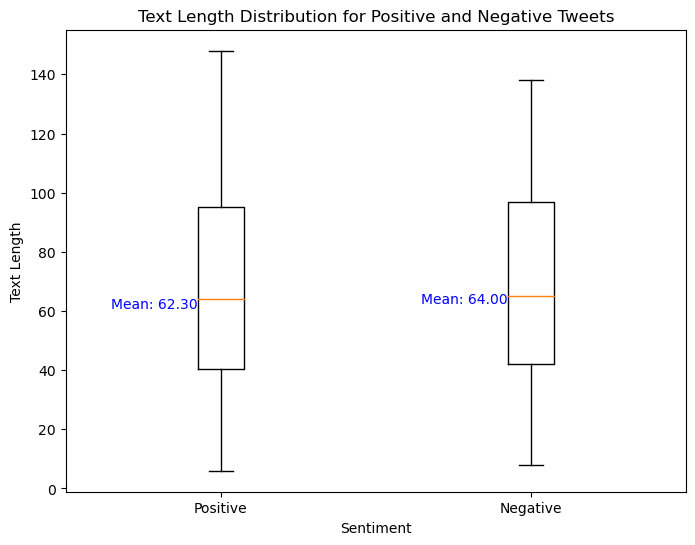

In [18]:
test_data['Text Length'] = test_data['text'].apply(len)

test_data_positive_tweets = test_data[test_data['sentiment'] == "positive"]
test_data_negative_tweets = test_data[test_data['sentiment'] == "negative"]

plt.figure(figsize=(8, 6))
boxplot = plt.boxplot([test_data_positive_tweets['Text Length'], test_data_negative_tweets['Text Length']],
                     labels=['Positive', 'Negative'])

for i, box in enumerate(boxplot['boxes']):
    y = box.get_ydata()
    x = box.get_xdata()
    mean = y.mean()
    plt.text(x[0], mean, f'Mean: {mean:.2f}', va='center', ha='right', color='blue')

plt.title('Text Length Distribution for Positive and Negative Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()

**Bar Chart of The Sentiment Distribution Within The Test Dataset**

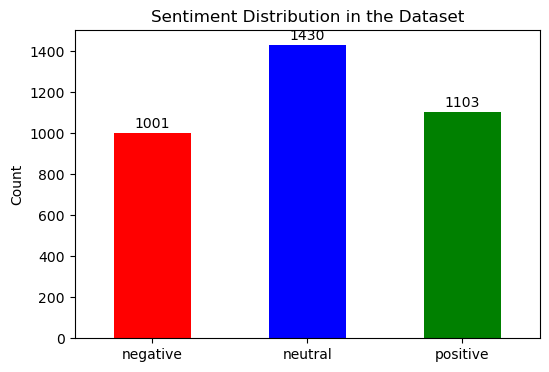

In [19]:
sentiment_counts = test_data['sentiment'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
ax = sentiment_counts.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Sentiment Distribution in the Dataset')
plt.ylabel('Count')

for i, v in enumerate(sentiment_counts):
    ax.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=10, color='black')

plt.xticks(rotation=0)
plt.show()


**Histogram of Tweet Length**

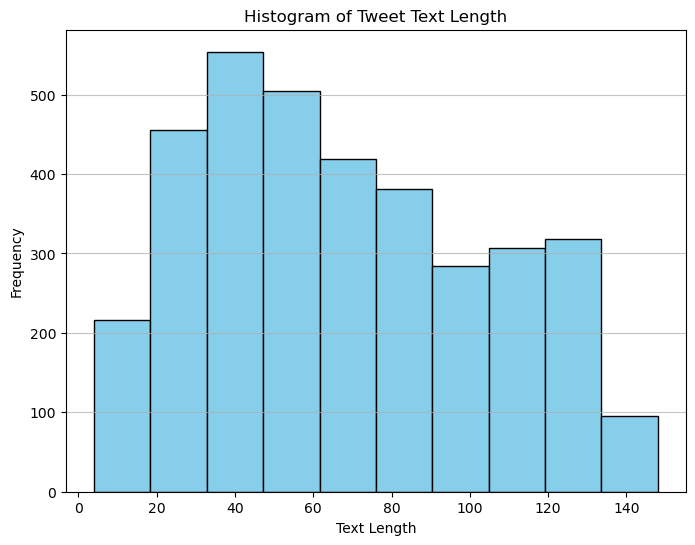

In [20]:
test_data['Text Length'] = test_data['text'].apply(len)

plt.figure(figsize=(8, 6))
plt.hist(test_data['Text Length'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Tweet Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Word Cloud of Most Tweeted Words**

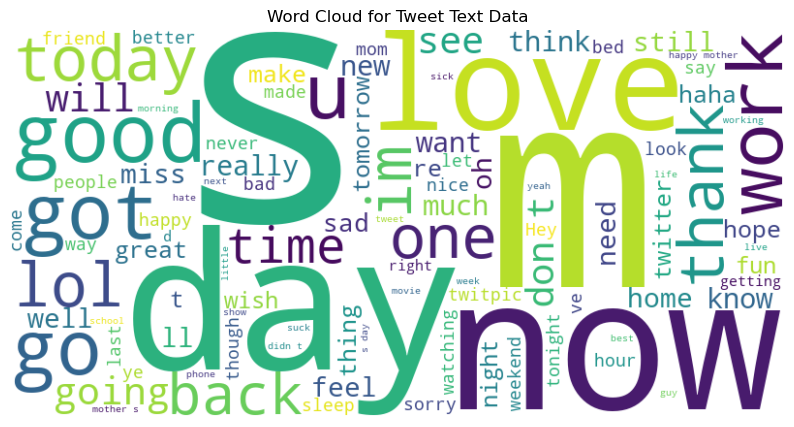

In [21]:
test_data_text_data = " ".join(test_data['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=100).generate(test_data_text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Tweet Text Data')
plt.show()

# Training and Testing for Models

**Creating a Copy of Test Dataset to Work On**

In [22]:
normalised_test_data = test_data.copy()

**Check & Describe The Copied Test Dataset**

In [23]:
normalised_test_data.describe()

Population -2020  Land Area (Km¬≤)  Density (P/Km¬≤)  Text Length
count      3.534000e+03     3.534000e+03      3534.000000  3534.000000
mean       3.941891e+07     6.722499e+05       348.894171    67.777589
std        1.468757e+08     1.839134e+06      1967.012367    35.590682
min        8.010000e+02     0.000000e+00         2.000000     4.000000
25%        1.968001e+06     2.281000e+04        35.000000    38.000000
50%        8.696453e+06     1.127600e+05        87.000000    63.000000
75%        2.843594e+07     5.279700e+05       214.000000    96.750000
max        1.439324e+09     1.637687e+07     26337.000000   148.000000

**Assign Feature & Target Column to 'x' and 'y'**

In [24]:
x = normalised_test_data['text'].values
y = normalised_test_data["sentiment"].values

print(x.shape)
print(y.shape)

(3534,)
(3534,)


**Split Into Training & Testing**

In [25]:
#Splitting The Data Into Training & Testing Sets (Scikit-learn, 2018)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

**Vectorize Training & Test Text Data**

In [26]:
# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Model One - Multinomial Naive Bayes (ML)

**Multinomial Naive Bayes Model**

In [27]:
model_one = MultinomialNB()
model_one.fit(x_train_tfidf, y_train)

MultinomialNB()

**Multinomial Naive Bayes Model Results**

Accuracy: 0.59
              precision    recall  f1-score   support

    negative       0.78      0.29      0.42       207
     neutral       0.51      0.88      0.65       286
    positive       0.76      0.49      0.60       214

    accuracy                           0.59       707
   macro avg       0.68      0.55      0.55       707
weighted avg       0.66      0.59      0.57       707



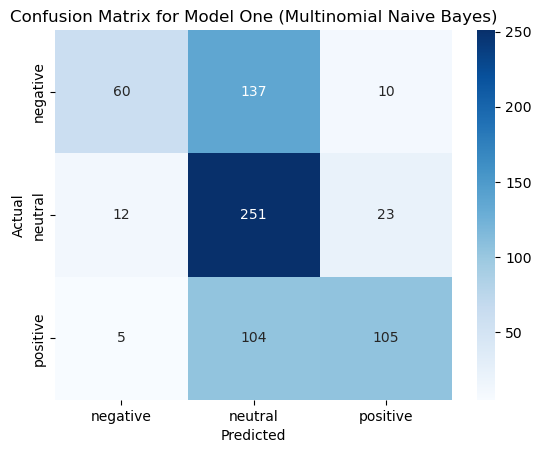

In [28]:
#Model One Predict
model_one_pred = model_one.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, model_one_pred)
model_one_report = classification_report(y_test, model_one_pred)

print(f'Accuracy: {accuracy:.2f}')
print(model_one_report)

#Model One Confusion Matrix
model_one_cm = confusion_matrix(y_test, model_one_pred)
class_names = ['negative', 'neutral', 'positive']
sns.heatmap(model_one_cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Model One (Multinomial Naive Bayes)')
plt.show()

**Best Multinomial Naive Bayes Model**

In [29]:
#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
mnb_class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

mnb_param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0],}

mnb_grid_search = GridSearchCV(MultinomialNB(class_prior=mnb_class_weights), mnb_param_grid, cv=5, refit='f1')

mnb_grid_search.fit(x_train_tfidf, y_train)

best_params_mnb = mnb_grid_search.best_params_

best_mnb_model = mnb_grid_search.best_estimator_

print("Best Hyperparameters for MNB:", best_params_mnb)
print(mnb_grid_search.best_estimator_)

Best Hyperparameters for MNB: {'alpha': 1.5}
MultinomialNB(alpha=1.5,
              class_prior=array([1.1868178 , 0.82371795, 1.0599925 ]))


**Best Multinomial Naive Bayes Model Results**

Accuracy: 0.60
              precision    recall  f1-score   support

    negative       0.55      0.70      0.61       207
     neutral       0.61      0.45      0.52       286
    positive       0.66      0.71      0.68       214

    accuracy                           0.60       707
   macro avg       0.60      0.62      0.60       707
weighted avg       0.60      0.60      0.59       707



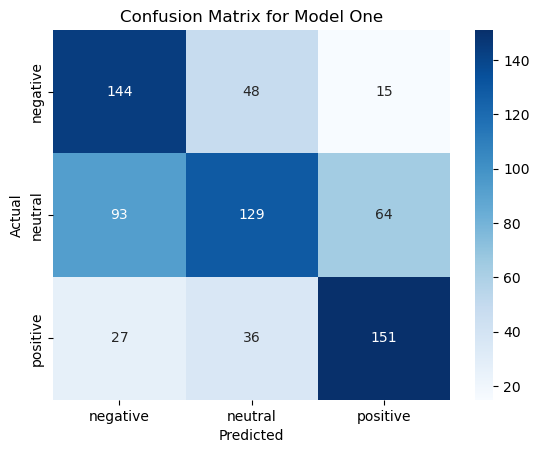

In [30]:
best_mnb_model_pred = best_mnb_model.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, best_mnb_model_pred)
best_mnb_model_report = classification_report(y_test, best_mnb_model_pred)

print(f'Accuracy: {accuracy:.2f}')
print(best_mnb_model_report)

best_mnb_model_cm = confusion_matrix(y_test, best_mnb_model_pred)
class_names = ['negative', 'neutral', 'positive']
sns.heatmap(best_mnb_model_cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Model One')
plt.show()

# Model Two - SVM (ML)

**SVM Model**

In [31]:
model_two = SVC()
model_two.fit(x_train_tfidf, y_train)

SVC()

**SVM Model Results**

Accuracy: 0.62
              precision    recall  f1-score   support

    negative       0.77      0.40      0.53       207
     neutral       0.53      0.84      0.65       286
    positive       0.78      0.54      0.64       214

    accuracy                           0.62       707
   macro avg       0.69      0.59      0.61       707
weighted avg       0.68      0.62      0.61       707



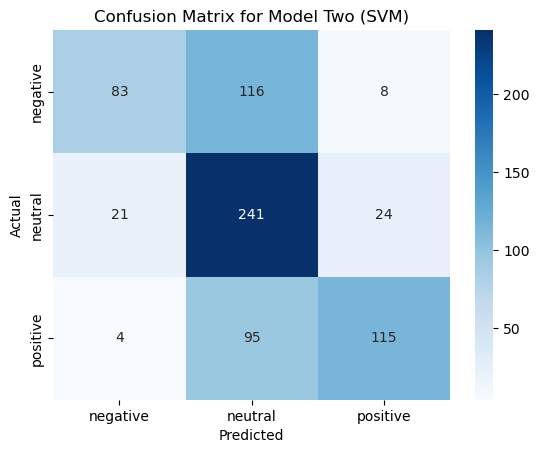

In [32]:
model_two_pred = model_two.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, model_two_pred)
model_two_report = classification_report(y_test, model_two_pred)

print(f'Accuracy: {accuracy:.2f}')
print(model_two_report)

model_two_cm = confusion_matrix(y_test, model_two_pred)
class_names = ['negative', 'neutral', 'positive']
sns.heatmap(model_two_cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Model Two (SVM)')
plt.show()

**Best SVM Model**

In [33]:
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
svm_param_grid = {'C': [0.001, 0.1, 1, 10, 100],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],}

svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5, scoring='f1_macro', refit=True)

svm_grid_search.fit(x_train_tfidf, y_train)

best_params_svm = svm_grid_search.best_params_

best_svm_model = svm_grid_search.best_estimator_

print("Best Hyperparameters for SVC:", best_params_svm)
print(svm_grid_search.best_estimator_)

Best Hyperparameters for SVC: {'C': 1, 'kernel': 'linear'}
SVC(C=1, kernel='linear')


Performed better removing class weight from 0.64 to 0.65

**Best SVM Model Results**

Accuracy: 0.65
              precision    recall  f1-score   support

    negative       0.71      0.57      0.63       207
     neutral       0.58      0.74      0.65       286
    positive       0.74      0.61      0.67       214

    accuracy                           0.65       707
   macro avg       0.68      0.64      0.65       707
weighted avg       0.67      0.65      0.65       707



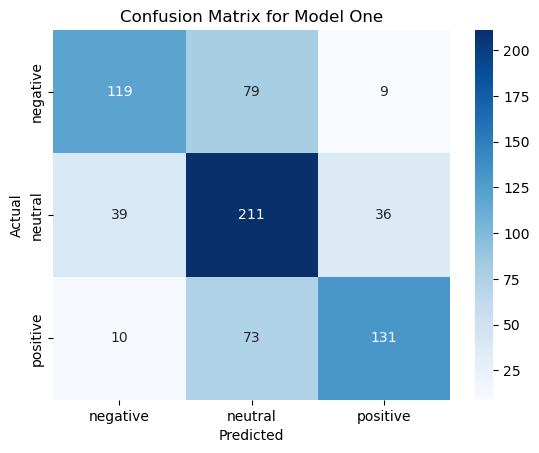

In [34]:
#Model Two Predict
best_svm_model_pred = best_svm_model.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, best_svm_model_pred)
best_svm_model_report = classification_report(y_test, best_svm_model_pred)

print(f'Accuracy: {accuracy:.2f}')
print(best_svm_model_report)

#Model Two Confusion Matrix
best_svm_model_cm = confusion_matrix(y_test, best_svm_model_pred)
class_names = ['negative', 'neutral', 'positive']
sns.heatmap(best_svm_model_cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Model One')
plt.show()

# Model Three - Logistic Regression (ML)

**Logistic Regression Model**

In [35]:
model_three = LogisticRegression()
model_three.fit(x_train_tfidf, y_train)

LogisticRegression()

**Logistic Regression Model Results**

Accuracy: 0.64
              precision    recall  f1-score   support

    negative       0.70      0.55      0.62       207
     neutral       0.58      0.73      0.65       286
    positive       0.72      0.63      0.67       214

    accuracy                           0.64       707
   macro avg       0.67      0.63      0.64       707
weighted avg       0.66      0.64      0.64       707



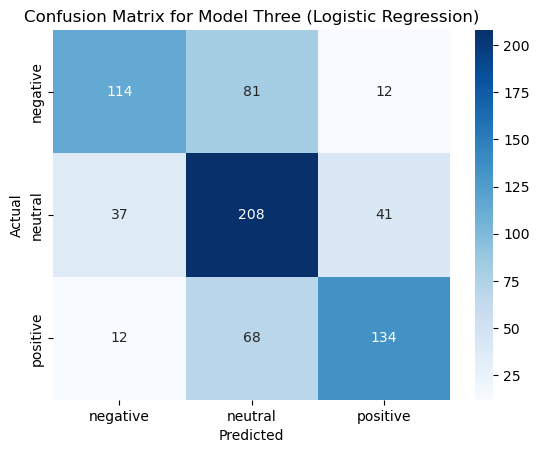

In [36]:
model_three_pred = model_three.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, model_three_pred)
model_three_report = classification_report(y_test, model_three_pred)

print(f'Accuracy: {accuracy:.2f}')
print(model_three_report)

model_three_cm = confusion_matrix(y_test, model_three_pred)
class_names = ['negative', 'neutral', 'positive']
sns.heatmap(model_three_cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Model Three (Logistic Regression)')
plt.show()

**Best Logistic Regression Model**

In [37]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
logreg_param_grid = {'C': [0.001, 0.1, 1, 10, 100],
                     'penalty': ['l2'],
                     'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                     'max_iter': [1000, 2000, 5000]}  

logreg_grid_search = GridSearchCV(LogisticRegression(), logreg_param_grid, cv=5, scoring='f1_macro', refit=True)

logreg_grid_search.fit(x_train_tfidf, y_train)

best_params_logreg = logreg_grid_search.best_params_

best_logreg_model = logreg_grid_search.best_estimator_

print("Best Hyperparameters for LR:", best_params_logreg)
print(logreg_grid_search.best_estimator_)

Best Hyperparameters for LR: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
LogisticRegression(C=10, max_iter=1000, solver='liblinear')


**Best Logistic Regression Model Results**

Accuracy: 0.64
              precision    recall  f1-score   support

    negative       0.65      0.59      0.62       207
     neutral       0.60      0.65      0.62       286
    positive       0.70      0.68      0.69       214

    accuracy                           0.64       707
   macro avg       0.65      0.64      0.65       707
weighted avg       0.65      0.64      0.64       707



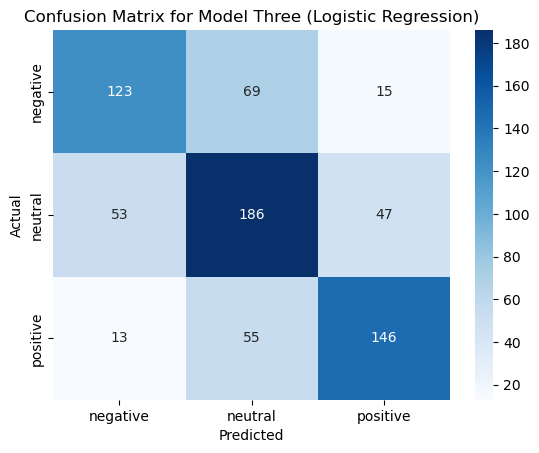

In [38]:
# Model Three Predict
best_logreg_model_pred = best_logreg_model.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, best_logreg_model_pred)
best_logreg_model_report = classification_report(y_test, best_logreg_model_pred)

print(f'Accuracy: {accuracy:.2f}')
print(best_logreg_model_report)

# Model Three Confusion Matrix
best_logreg_model_cm = confusion_matrix(y_test, best_logreg_model_pred)
class_names = ['negative', 'neutral', 'positive']
sns.heatmap(best_logreg_model_cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Model Three (Logistic Regression)')
plt.show()

# Model Four - Random Forest (ML)

**Random Forest Model**

In [39]:
model_four = RandomForestClassifier()
model_four.fit(x_train_tfidf, y_train)

RandomForestClassifier()

**Random Forest Model Results**

Accuracy: 0.63
              precision    recall  f1-score   support

    negative       0.69      0.45      0.55       207
     neutral       0.57      0.71      0.63       286
    positive       0.68      0.68      0.68       214

    accuracy                           0.63       707
   macro avg       0.65      0.61      0.62       707
weighted avg       0.64      0.63      0.62       707



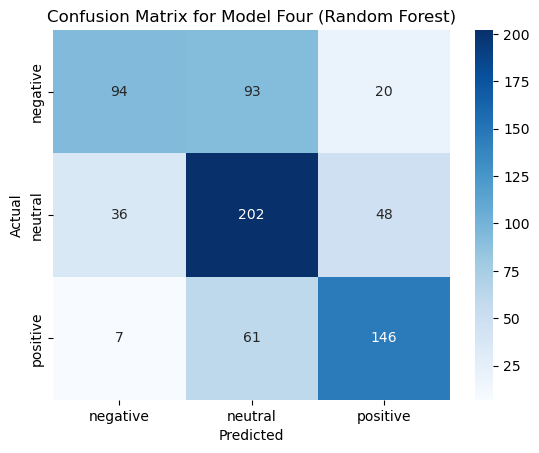

In [40]:
#Model Four Confusion Matrix
model_four_pred = model_four.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, model_four_pred)
model_four_report = classification_report(y_test, model_four_pred)

print(f'Accuracy: {accuracy:.2f}')
print(model_four_report)

#Model Four Confusion Matrix
model_four_cm = confusion_matrix(y_test, model_four_pred)
class_names = ['negative', 'neutral', 'positive']
sns.heatmap(model_four_cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Model Four (Random Forest)')
plt.show()

**Best Random Forest Model**

In [41]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf_param_grid = {'n_estimators': [10, 100, 1000],
                 'max_features': ['sqrt', 'log2'],}


rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='f1_macro', refit=True)

rf_grid_search.fit(x_train_tfidf, y_train)

best_params_rf = rf_grid_search.best_params_

best_rf_model = rf_grid_search.best_estimator_

print("Best Hyperparameters for RF:", best_params_rf)
print(rf_grid_search.best_estimator_)

Best Hyperparameters for RF: {'max_features': 'sqrt', 'n_estimators': 1000}
RandomForestClassifier(n_estimators=1000)


**Best Random Forest Model Results**

Accuracy: 0.64
              precision    recall  f1-score   support

    negative       0.70      0.49      0.57       207
     neutral       0.58      0.71      0.64       286
    positive       0.70      0.69      0.69       214

    accuracy                           0.64       707
   macro avg       0.66      0.63      0.63       707
weighted avg       0.65      0.64      0.64       707



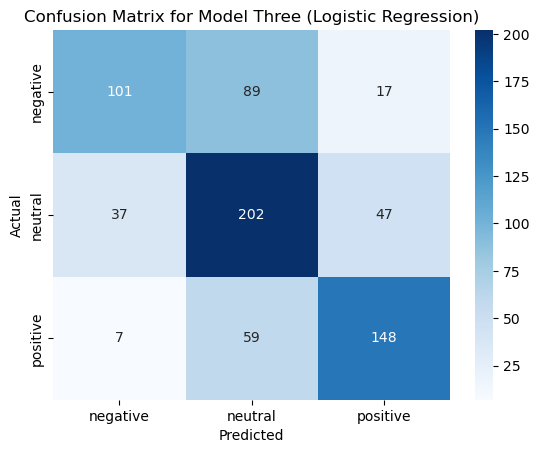

In [42]:
best_rf_model_pred = best_rf_model.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, best_rf_model_pred)
best_rf_model_report = classification_report(y_test, best_rf_model_pred)

print(f'Accuracy: {accuracy:.2f}')
print(best_rf_model_report)

best_rf_model_cm = confusion_matrix(y_test, best_rf_model_pred)
class_names = ['negative', 'neutral', 'positive']
sns.heatmap(best_rf_model_cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Model Three (Logistic Regression)')
plt.show()

# Initial Data Analysis of Dataset

**Load in Dataset**

In [43]:
data = pd.read_csv('Test Datasets/Twitter Sentiment Dataset on Amazon (January - June Tweets).csv')
#data = pd.read_csv('Test Datasets/Twitter Sentiment Dataset on Amazon (December Tweets).csv')

**Shape of the Dataset**

In [44]:
#The size of the data frame
data.shape

(7159, 73)

**Printing the Dataset**

In [45]:
#Will print the data frame
data

Source.Name                                             avatar  \
0     April Tweets.csv                                                NaN   
1     April Tweets.csv                                                NaN   
2     April Tweets.csv                                                NaN   
3     April Tweets.csv                                                NaN   
4     April Tweets.csv                                                NaN   
...                ...                                                ...   
7154    May Tweets.csv                                                NaN   
7155    May Tweets.csv  https://pbs.twimg.com/profile_images/836032619...   
7156    May Tweets.csv  https://pbs.twimg.com/profile_images/155100159...   
7157    May Tweets.csv  https://pbs.twimg.com/profile_images/247125002...   
7158    May Tweets.csv                                                NaN   

                                               fullname            id  \
0                                                   NaN  1.652830e+18   
1                                                   NaN  1.652830e+18   
2                                                   NaN  1.652820e+18   
3                                                   NaN  1.652830e+18   
4                                                   NaN  1.652830e+18   
...                                                 ...           ...   
7154                                                NaN  1.664050e+18   
7155                                   Ellie W üá∫üá∏ üá®üá± ‚öæÔ∏è  1.664050e+18   
7156  RTX 40/RX 7K üì¢ + GPU/CPU Drop + Price Drop alerts  1.664050e+18   
7157                                   ARkstorm Prepper  1.664050e+18   
7158                                                NaN  1.664050e+18   

                                             images/0 images/1 images/2  \
0     https://pbs.twimg.com/media/FvADYLiaIAEe8X8.png      NaN      NaN   
1                                                 NaN      NaN      NaN   
2                                                 NaN      NaN      NaN   
3                                                 NaN      NaN      NaN   
4                                                 NaN      NaN      NaN   
...                                               ...      ...      ...   
7154  https://pbs.twimg.com/media/FxfiA3GXwAEi32k.jpg      NaN      NaN   
7155                                              NaN      NaN      NaN   
7156  https://pbs.twimg.com/media/Fxfh0Z6WcAAvP6O.jpg      NaN      NaN   
7157                                              NaN      NaN      NaN   
7158  https://pbs.twimg.com/media/Fxfh8LRXsAACU1h.jpg      NaN      NaN   

     images/3 images/4  isQuote  ...  user/totalFollowing  user/totalLikes  \
0         NaN      NaN    False  ...                129.0           2270.0   
1         NaN      NaN    False  ...                639.0            175.0   
2         NaN      NaN    False  ...                 75.0          57151.0   
3         NaN      NaN    False  ...               8745.0        1214902.0   
4         NaN      NaN    False  ...               1525.0          31891.0   
...       ...      ...      ...  ...                  ...              ...   
7154      NaN      NaN    False  ...                177.0            733.0   
7155      NaN      NaN    False  ...               6625.0           1841.0   
7156      NaN      NaN    False  ...                  9.0            660.0   
7157      NaN      NaN    False  ...               5558.0           7530.0   
7158      NaN      NaN    False  ...                437.0          52839.0   

     user/totalTweets                              user/url  \
0               319.0      https://twitter.com//SuperSimpin   
1             47807.0    https://twitter.com//EspineuxAlpha   
2          11346813.0       https://twitter.com//AmazonHelp   
3            163765.0        https://twitter.com//shun97910   
4              4874.0     https://twi

**First 5 Rows of The Dataset**

In [46]:
data.head(5)

Source.Name avatar fullname            id  \
0  April Tweets.csv    NaN      NaN  1.652830e+18   
1  April Tweets.csv    NaN      NaN  1.652830e+18   
2  April Tweets.csv    NaN      NaN  1.652820e+18   
3  April Tweets.csv    NaN      NaN  1.652830e+18   
4  April Tweets.csv    NaN      NaN  1.652830e+18   

                                          images/0 images/1 images/2 images/3  \
0  https://pbs.twimg.com/media/FvADYLiaIAEe8X8.png      NaN      NaN      NaN   
1                                              NaN      NaN      NaN      NaN   
2                                              NaN      NaN      NaN      NaN   
3                                              NaN      NaN      NaN      NaN   
4                                              NaN      NaN      NaN      NaN   

  images/4  isQuote  ...  user/totalFollowing  user/totalLikes  \
0      NaN    False  ...                129.0           2270.0   
1      NaN    False  ...                639.0            175.0   
2      NaN    False  ...                 75.0          57151.0   
3      NaN    False  ...               8745.0        1214902.0   
4      NaN    False  ...               1525.0          31891.0   

  user/totalTweets                            user/url user/userFullName  \
0            319.0    https://twitter.com//SuperSimpin            Simpin   
1          47807.0  https://twitter.com//EspineuxAlpha    Margaret Walsh   
2       11346813.0     https://twitter.com//AmazonHelp       Amazon Help   
3         163765.0      https://twitter.com//shun97910       ÁäÄÂîØ„ÅèÔΩûÔΩûÔΩû„Çì(Ï†ïÏú†)   
4           4874.0   https://twitter.com//AboutGabbing           Ant Nav   

    user/username user/verified                   user/website username  \
0    @SuperSimpin         False                            NaN      NaN   
1  @EspineuxAlpha         False  amazon.com/Margaret-Walsh/e/‚Ä¶      NaN   
2     @AmazonHelp         False                amazon.com/help      NaN   
3      @shun97910         False                            NaN      NaN   
4   @AboutGabbing         False                            NaN      NaN   

  verified  
0    False  
1    False  
2    False  
3    False  
4    False  

[5 rows x 73 columns]

**Last 5 Rows of The Dataset**

In [47]:
data.tail(5)

Source.Name                                             avatar  \
7154  May Tweets.csv                                                NaN   
7155  May Tweets.csv  https://pbs.twimg.com/profile_images/836032619...   
7156  May Tweets.csv  https://pbs.twimg.com/profile_images/155100159...   
7157  May Tweets.csv  https://pbs.twimg.com/profile_images/247125002...   
7158  May Tweets.csv                                                NaN   

                                               fullname            id  \
7154                                                NaN  1.664050e+18   
7155                                   Ellie W üá∫üá∏ üá®üá± ‚öæÔ∏è  1.664050e+18   
7156  RTX 40/RX 7K üì¢ + GPU/CPU Drop + Price Drop alerts  1.664050e+18   
7157                                   ARkstorm Prepper  1.664050e+18   
7158                                                NaN  1.664050e+18   

                                             images/0 images/1 images/2  \
7154  https://pbs.twimg.com/media/FxfiA3GXwAEi32k.jpg      NaN      NaN   
7155                                              NaN      NaN      NaN   
7156  https://pbs.twimg.com/media/Fxfh0Z6WcAAvP6O.jpg      NaN      NaN   
7157                                              NaN      NaN      NaN   
7158  https://pbs.twimg.com/media/Fxfh8LRXsAACU1h.jpg      NaN      NaN   

     images/3 images/4  isQuote  ...  user/totalFollowing  user/totalLikes  \
7154      NaN      NaN    False  ...                177.0            733.0   
7155      NaN      NaN    False  ...               6625.0           1841.0   
7156      NaN      NaN    False  ...                  9.0            660.0   
7157      NaN      NaN    False  ...               5558.0           7530.0   
7158      NaN      NaN    False  ...                437.0          52839.0   

     user/totalTweets                              user/url  \
7154           2021.0     https://twitter.com//SWJournalist   
7155         367794.0       https://twitter.com//eswright18   
7156          83509.0  https://twitter.com//LeBlarstOfTimes   
7157         170473.0  https://twitter.com//ARkstormPrepper   
7158          27645.0   https://twitter.com//TheBugleDaily1   

                                      user/userFullName     user/username  \
7154                               Southwest Journalist     @SWJournalist   
7155                                   Ellie W üá∫üá∏ üá®üá± ‚öæÔ∏è       @eswright18   
7156  RTX 40/RX 7K üì¢ + GPU/CPU Drop + Price Drop alerts  @LeBlarstOfTimes   
7157                                   ARkstorm Prepper  @ARkstormPrepper   
7158                                    The Bugle Daily   @TheBugleDaily1   

     user/verified                   user/website          username verified  
7154         False               swjournalist.com               NaN    False  
7155         False                            NaN       @eswright18    False  
7156         False               links.blorst.xyz  @LeBlarstOfTimes    False  
7157         False            ronfoster.webs.com/  @ARkstormPrepper    False  
7158         False  piped.video/channel/UClk0QVO‚Ä¶               NaN    False  

[5 rows x 73 columns]

**Data Types in The Dataset**

In [48]:
data.dtypes

Source.Name       object
avatar            object
fullname          object
id               float64
images/0          object
                  ...   
user/username     object
user/verified     object
user/website      object
username          object
verified          object
Length: 73, dtype: object

**Dataset Description**

In [49]:
data.describe().T

count          mean           std           min  \
id                   7159.0  1.640572e+18  1.865526e+16  1.620550e+18   
likes                7159.0  6.295712e+00  8.901662e+01  0.000000e+00   
quotedTweet/avatar      0.0           NaN           NaN           NaN   
quotes               7159.0  1.301858e-01  1.873428e+00  0.000000e+00   
replies              7159.0  5.780137e-01  7.594963e+00  0.000000e+00   
retweets             7159.0  1.431205e+00  2.098993e+01  0.000000e+00   
user/totalFollowers  5105.0  7.636282e+04  1.487224e+06  0.000000e+00   
user/totalFollowing  5105.0  3.029258e+03  1.633845e+04  0.000000e+00   
user/totalLikes      5105.0  2.904560e+04  7.368982e+04  0.000000e+00   
user/totalTweets     5105.0  1.899455e+05  8.414103e+05  1.000000e+00   

                              25%           50%           75%           max  
id                   1.620570e+18  1.630720e+18  1.652820e+18  1.674930e+18  
likes                0.000000e+00  0.000000e+00  1.000000e+00  5.273000e+03  
quotedTweet/avatar            NaN           NaN           NaN           NaN  
quotes               0.000000e+00  0.000000e+00  0.000000e+00  9.600000e+01  
replies              0.000000e+00  0.000000e+00  0.000000e+00  5.440000e+02  
retweets             0.000000e+00  0.000000e+00  0.000000e+00  7.840000e+02  
user/totalFollowers  1.670000e+02  6.440000e+02  3.038000e+03  6.208628e+07  
user/totalFollowing  1.210000e+02  4.630000e+02  1.999000e+03  4.333160e+05  
user/totalLikes      1.010000e+02  3.582000e+03  2.366300e+04  1.214902e+06  
user/totalTweets     5.415000e+03  2.518800e+04  1.352260e+05  1.134694e+07

**Columns in Dataset**

In [50]:
data.columns

Index(['Source.Name', 'avatar', 'fullname', 'id', 'images/0', 'images/1',
       'images/2', 'images/3', 'images/4', 'isQuote', 'isRetweet', 'likes',
       'links/0', 'links/1', 'links/2', 'links/3', 'links/4', 'links/5',
       'links/6', 'links/7', 'links/8', 'links/9', 'links/10', 'links/11',
       'links/12', 'links/13', 'links/14', 'links/15', 'links/16', 'links/17',
       'links/18', 'links/19', 'links/20', 'quotedTweet/avatar',
       'quotedTweet/fullname', 'quotedTweet/images/0', 'quotedTweet/images/1',
       'quotedTweet/images/2', 'quotedTweet/images/3', 'quotedTweet/links/0',
       'quotedTweet/links/1', 'quotedTweet/links/2', 'quotedTweet/links/3',
       'quotedTweet/links/4', 'quotedTweet/links/5', 'quotedTweet/links/6',
       'quotedTweet/links/7', 'quotedTweet/text', 'quotedTweet/timestamp',
       'quotedTweet/url', 'quotedTweet/username', 'quotes', 'replies',
       'retweets', 'searchQuery', 'text', 'timestamp', 'url', 'user/avatar',
       'user/description',

**Check for Missing Values in Dataset**

In [51]:
#Code to check if all data is present
if data.isnull().values.any():
    print("There are missing records in the CSV file.")
else:
    print("All records are present in the CSV file.")

There are missing records in the CSV file.


**Check Missing Values in Target Columns**

In [52]:
columns_to_check_missing_values = ['text', 'id', 'likes', 'quotes', 'replies', 'retweets', 'searchQuery', 'timestamp']

# Iterate through the columns and check for missing values
for column_name in columns_to_check_missing_values:
    if data[column_name].isnull().any():
        print(f"There are missing values in the column '{column_name}'.")
    else:
        print(f"No missing values in the column '{column_name}'.")

No missing values in the column 'text'.
No missing values in the column 'id'.
No missing values in the column 'likes'.
No missing values in the column 'quotes'.
No missing values in the column 'replies'.
No missing values in the column 'retweets'.
No missing values in the column 'searchQuery'.
No missing values in the column 'timestamp'.


# Exploratory Data Analysis


**Create Copy of Dataframe to Work On**

In [53]:
normalised_data = data.copy()

**Check Columns of Dataset**

In [54]:
normalised_data.columns

Index(['Source.Name', 'avatar', 'fullname', 'id', 'images/0', 'images/1',
       'images/2', 'images/3', 'images/4', 'isQuote', 'isRetweet', 'likes',
       'links/0', 'links/1', 'links/2', 'links/3', 'links/4', 'links/5',
       'links/6', 'links/7', 'links/8', 'links/9', 'links/10', 'links/11',
       'links/12', 'links/13', 'links/14', 'links/15', 'links/16', 'links/17',
       'links/18', 'links/19', 'links/20', 'quotedTweet/avatar',
       'quotedTweet/fullname', 'quotedTweet/images/0', 'quotedTweet/images/1',
       'quotedTweet/images/2', 'quotedTweet/images/3', 'quotedTweet/links/0',
       'quotedTweet/links/1', 'quotedTweet/links/2', 'quotedTweet/links/3',
       'quotedTweet/links/4', 'quotedTweet/links/5', 'quotedTweet/links/6',
       'quotedTweet/links/7', 'quotedTweet/text', 'quotedTweet/timestamp',
       'quotedTweet/url', 'quotedTweet/username', 'quotes', 'replies',
       'retweets', 'searchQuery', 'text', 'timestamp', 'url', 'user/avatar',
       'user/description',

**Remove Unncessary Columns**

In [55]:
columns_to_keep = [
    'id', 'likes', 'quotes', 'replies', 'retweets', 'searchQuery', 'text', 'timestamp', 'user/location', 'verified'
]

normalised_data = normalised_data[columns_to_keep]

print(normalised_data)

                id  likes  quotes  replies  retweets searchQuery  \
0     1.652830e+18      0       0        2         0      Amazon   
1     1.652830e+18      0       0        0         0      Amazon   
2     1.652820e+18      1       0        0         0      Amazon   
3     1.652830e+18      0       0        0         0      Amazon   
4     1.652830e+18      0       0        0         0      Amazon   
...            ...    ...     ...      ...       ...         ...   
7154  1.664050e+18      0       0        0         0      Amazon   
7155  1.664050e+18      0       0        0         0      Amazon   
7156  1.664050e+18      0       0        0         1      Amazon   
7157  1.664050e+18      0       0        0         0      Amazon   
7158  1.664050e+18     35       0        4         3      Amazon   

                                                   text         timestamp  \
0     If you find these transactions, the first thin...  01/05/2023 00:59   
1     Sherlock Holmes and the

**Check for Missing Values**

In [56]:
#Code to check if all data is present
if normalised_data.isnull().values.any():
    print("There are missing records in the CSV file.")
else:
    print("All records are present in the CSV file.")

There are missing records in the CSV file.


**Check for Missing Values in Target Column**

In [57]:
column_name = 'text'

if normalised_data[column_name].isnull().any():
    print(f"There are missing values in the column '{column_name}'.")
else:
    print(f"No missing values in the column '{column_name}'.")


No missing values in the column 'text'.


**Check Data Types**

In [58]:
normalised_data.dtypes

id               float64
likes              int64
quotes             int64
replies            int64
retweets           int64
searchQuery       object
text              object
timestamp         object
user/location     object
verified          object
dtype: object

**Convert Timestamp for Both Excel Deafult & Apify Default**

In [59]:
def check_and_convert_timestamp(normalised_data):
    try:
        normalised_data['timestamp'] = pd.to_datetime(normalised_data['timestamp'], format='%d/%m/%Y %H:%M')
    except ValueError:
        try:
            normalised_data['timestamp'] = pd.to_datetime(normalised_data['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')
        except ValueError:
            # If both formats fail, handle the error or do something else
            print("Error: Unable to parse timestamp in either format")

check_and_convert_timestamp(normalised_data)

**Check Data Type to See if Timestamp Changed**

In [60]:
normalised_data.dtypes

id                      float64
likes                     int64
quotes                    int64
replies                   int64
retweets                  int64
searchQuery              object
text                     object
timestamp        datetime64[ns]
user/location            object
verified                 object
dtype: object

# Running Best Model on Dataset


**Run Best Model on Dataset (Tuned SVM Model)**

In [61]:
model = SVC(C=1, kernel='linear')
model.fit(x_train_tfidf, y_train)

SVC(C=1, kernel='linear')

In [62]:
tweets = normalised_data['text']
tweets_tfidf = tfidf_vectorizer.transform(tweets)
sentiment_prediction = model.predict(tweets_tfidf)

normalised_data['sentiment'] = sentiment_prediction

**Print Dataset With New Sentiment Column**

In [63]:
normalised_data

id  likes  quotes  replies  retweets searchQuery  \
0     1.652830e+18      0       0        2         0      Amazon   
1     1.652830e+18      0       0        0         0      Amazon   
2     1.652820e+18      1       0        0         0      Amazon   
3     1.652830e+18      0       0        0         0      Amazon   
4     1.652830e+18      0       0        0         0      Amazon   
...            ...    ...     ...      ...       ...         ...   
7154  1.664050e+18      0       0        0         0      Amazon   
7155  1.664050e+18      0       0        0         0      Amazon   
7156  1.664050e+18      0       0        0         1      Amazon   
7157  1.664050e+18      0       0        0         0      Amazon   
7158  1.664050e+18     35       0        4         3      Amazon   

                                                   text           timestamp  \
0     If you find these transactions, the first thin... 2023-05-01 00:59:00   
1     Sherlock Holmes and the Case of the Perplexed ... 2023-05-01 00:59:00   
2     We want to thank you for your feedback. It's i... 2023-05-01 00:59:00   
3                                                Amazon 2023-05-01 00:59:00   
4                                    Well yeah, duh lol 2023-05-01 00:59:00   
...                                                 ...                 ...   
7154  The new Amazon Prime Video docuseries The Ride... 2023-06-01 00:12:00   
7155  The Beat: $1,000 Amazon e-Gift Card Sweepstake... 2023-06-01 00:11:00   
7156  Amazon [$269.99]: XFX Speedster SWFT210 Radeon... 2023-06-01 00:11:00   
7157  An Old Man And His Axe: A Prepper fiction book... 2023-06-01 00:10:00   
7158  They are about to learn what Amazon learned!\n... 2023-06-01 00:11:00   

             user/location verified sentiment  
0      Melbourne, Victoria    False   neutral  
1     Melbourne, Australia    False   neutral  
2                      NaN    False   neutral  
3                  Á•ûÂ•àÂ∑ùÁúåÊ®™ÊµúÂ∏Ç    False  negative  
4                Iowa, USA    False   neutral  
...                    ...      ...       ...  
7154         Austin, Texas    False   neutral  
7155         Garland Texas    False  negative  
7156               Chicago    False   neutral  
7157               Alabama    False   neutral  
7158         United States    False   neutral  

[7159 rows x 11 columns]

**Print The Target Column With Sentiment Column**

In [64]:
normalised_data[['id', 'text', 'sentiment']]

id                                               text  \
0     1.652830e+18  If you find these transactions, the first thin...   
1     1.652830e+18  Sherlock Holmes and the Case of the Perplexed ...   
2     1.652820e+18  We want to thank you for your feedback. It's i...   
3     1.652830e+18                                             Amazon   
4     1.652830e+18                                 Well yeah, duh lol   
...            ...                                                ...   
7154  1.664050e+18  The new Amazon Prime Video docuseries The Ride...   
7155  1.664050e+18  The Beat: $1,000 Amazon e-Gift Card Sweepstake...   
7156  1.664050e+18  Amazon [$269.99]: XFX Speedster SWFT210 Radeon...   
7157  1.664050e+18  An Old Man And His Axe: A Prepper fiction book...   
7158  1.664050e+18  They are about to learn what Amazon learned!\n...   

     sentiment  
0      neutral  
1      neutral  
2      neutral  
3     negative  
4      neutral  
...        ...  
7154   neutral  
7155  negative  
7156   neutral  
7157   neutral  
7158   neutral  

[7159 rows x 3 columns]

# Checking New Labelled Amazon Dataset with VADER (NLTK) and BERT Models (DL)


In [48]:
#https://www.youtube.com/watch?v=QpzMWQvxXWk - YouTube video code is referenced

**Print the 427 Row**

In [65]:
print(normalised_data.iloc[427])

id                                           1652820000000000000.0
likes                                                            0
quotes                                                           0
replies                                                          0
retweets                                                         0
searchQuery                                                 Amazon
text             But you needed to keep Amazon, Walmart, UPS, F...
timestamp                                      2023-05-01 00:33:00
user/location                                                  NaN
verified                                                     False
sentiment                                                  neutral
Name: 427, dtype: object


In [66]:
example = normalised_data['text'][427]
print(example)

But you needed to keep Amazon, Walmart, UPS, FedEx going so people could keep shopping, the lives of the workers there didn't matter to them.


**Using NLTK to Create Tokens Within The Text Column**

In [67]:
nltk.word_tokenize(example)

['But',
 'you',
 'needed',
 'to',
 'keep',
 'Amazon',
 ',',
 'Walmart',
 ',',
 'UPS',
 ',',
 'FedEx',
 'going',
 'so',
 'people',
 'could',
 'keep',
 'shopping',
 ',',
 'the',
 'lives',
 'of',
 'the',
 'workers',
 'there',
 'did',
 "n't",
 'matter',
 'to',
 'them',
 '.']

**Calculate Polarity Score Using Vader on Row 427**

In [68]:
sia = SentimentIntensityAnalyzer()

In [69]:
sia.polarity_scores(example)

{'neg': 0.042, 'neu': 0.879, 'pos': 0.078, 'compound': 0.2356}

**Load Pre-Trained BERT Model**

In [70]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

C:\Users\Faris\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
C:\Users\Faris\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\transformers\modeling_utils.py:519: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explici

**Apply BERT Model to Row 427**

In [71]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.41119084, 'roberta_neu': 0.45936462, 'roberta_pos': 0.12944452}


In [72]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

**Run Both Vader & BERT on All Entries Of Dataset**

In [73]:
normalised_data_with_scores = normalised_data.copy()

In [74]:
res = {}
for i, row in tqdm(normalised_data_with_scores.iterrows(), total=len(normalised_data_with_scores)):
    try:
        text = row['text']
        myid = row['id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')


  0%|          | 0/7159 [00:00<?, ?it/s]

**Show Modified Dataframe With All Results**

In [75]:
normalised_data_with_scores = pd.DataFrame(res).T
normalised_data_with_scores

vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
1.652830e+18      0.000      1.000      0.000          0.0000     0.898099   
1.652820e+18      0.000      0.715      0.285          0.2481     0.004818   
1.652810e+18      0.000      0.629      0.371          0.9442     0.001373   
1.630720e+18      0.065      0.807      0.128          0.2013     0.467180   
1.630710e+18      0.106      0.847      0.047         -0.4582     0.948224   
1.630700e+18      0.135      0.338      0.527          0.7003     0.056359   
1.620570e+18      0.000      0.962      0.038          0.1779     0.011014   
1.620560e+18      0.000      0.710      0.290          0.6486     0.032772   
1.620550e+18      0.000      1.000      0.000          0.0000     0.012795   
1.674930e+18      0.000      0.827      0.173          0.8217     0.001076   
1.674920e+18      0.000      0.370      0.630          0.1779     0.154342   
1.641950e+18      0.134      0.788      0.079         -0.4098     0.533507   
1.641940e+18      0.000      0.827      0.173          0.7269     0.007736   
1.664060e+18      0.000      1.000      0.000          0.0000     0.072158   
1.664050e+18      0.000      0.801      0.199          0.2481     0.436043   

              roberta_neu  roberta_pos  
1.652830e+18     0.090520     0.011381  
1.652820e+18     0.131324     0.863858  
1.652810e+18     0.058516     0.940111  
1.630720e+18     0.403004     0.129817  
1.630710e+18     0.047406     0.004370  
1.630700e+18     0.629998     0.313643  
1.620570e+18     0.579041     0.409945  
1.620560e+18     0.478917     0.488311  
1.620550e+18     0.469835     0.517370  
1.674930e+18     0.047283     0.951640  
1.674920e+18     0.723825     0.121833  
1.641950e+18     0.441556     0.024937  
1.641940e+18     0.201178     0.791087  
1.664060e+18     0.714039     0.213803  
1.664050e+18     0.467462     0.096495

**Merge Scores With Sentiment from Model for Evaluation**

In [76]:
normalised_data_with_scores = normalised_data_with_scores.reset_index().rename(columns={'index': 'id'})
normalised_data_with_scores = normalised_data_with_scores.merge(normalised_data, how='left')

In [77]:
normalised_data_with_scores

id  vader_neg  vader_neu  vader_pos  vader_compound  \
0     1.652830e+18        0.0      1.000      0.000          0.0000   
1     1.652830e+18        0.0      1.000      0.000          0.0000   
2     1.652830e+18        0.0      1.000      0.000          0.0000   
3     1.652830e+18        0.0      1.000      0.000          0.0000   
4     1.652830e+18        0.0      1.000      0.000          0.0000   
...            ...        ...        ...        ...             ...   
7154  1.664050e+18        0.0      0.801      0.199          0.2481   
7155  1.664050e+18        0.0      0.801      0.199          0.2481   
7156  1.664050e+18        0.0      0.801      0.199          0.2481   
7157  1.664050e+18        0.0      0.801      0.199          0.2481   
7158  1.664050e+18        0.0      0.801      0.199          0.2481   

      roberta_neg  roberta_neu  roberta_pos  likes  quotes  replies  retweets  \
0        0.898099     0.090520     0.011381      0       0        2         0   
1        0.898099     0.090520     0.011381      0       0        0         0   
2        0.898099     0.090520     0.011381      0       0        0         0   
3        0.898099     0.090520     0.011381      0       0        0         0   
4        0.898099     0.090520     0.011381      0       0        1         0   
...           ...          ...          ...    ...     ...      ...       ...   
7154     0.436043     0.467462     0.096495      0       0        0         0   
7155     0.436043     0.467462     0.096495      0       0        0         0   
7156     0.436043     0.467462     0.096495      0       0        0         1   
7157     0.436043     0.467462     0.096495      0       0        0         0   
7158     0.436043     0.467462     0.096495     35       0        4         3   

     searchQuery                                               text  \
0         Amazon  If you find these transactions, the first thin...   
1         Amazon  Sherlock Holmes and the Case of the Perplexed ...   
2         Amazon                                             Amazon   
3         Amazon                                 Well yeah, duh lol   
4         Amazon  @amazon we paying over $100 for Prime, 2-day s...   
...          ...                                                ...   
7154      Amazon  The new Amazon Prime Video docuseries The Ride...   
7155      Amazon  The Beat: $1,000 Amazon e-Gift Card Sweepstake...   
7156      Amazon  Amazon [$269.99]: XFX Speedster SWFT210 Radeon...   
7157      Amazon  An Old Man And His Axe: A Prepper fiction book...   
7158      Amazon  They are about to learn what Amazon learned!\n...   

               timestamp         user/location verified sentiment  
0    2023-05-01 00:59:00   Melbourne, Victoria    False   neutral  
1    2023-05-01 00:59:00  Melbourne, Australia    False   neutral  
2    2023-05-01 00:59:00               Á•ûÂ•àÂ∑ùÁúåÊ®™ÊµúÂ∏Ç    False  negative  
3    2023-05-01 00:59:00             Iowa, USA    False   neutral  
4    2023-05-01 00:59:00                     üåë    False   neutral  
...                  ...                   ...      ...       ...  
7154 2023-06-01 00:12:00         Austin, Texas    False   neutral  
7155 2023-06-01 00:11:00         Garland Texas    False  negative  
7156 2023-06-01 00:11:00               Chicago    False   neutral  
7157 2023-06-01 00:10:00               Alabama    False   neutral  
7158 2023-06-01 00:11:00         United States    False   neutral  

[7159 rows x 18 columns]

In [78]:
normalised_data_with_scores.to_csv('Twitter Sentiment Dataset on Amazon (Labelled and Scores).csv', index=False)

# Analysing Amazon Dataset


**Print Dataset**

In [80]:
normalised_data

id  likes  quotes  replies  retweets searchQuery  \
0     1.652830e+18      0       0        2         0      Amazon   
1     1.652830e+18      0       0        0         0      Amazon   
2     1.652820e+18      1       0        0         0      Amazon   
3     1.652830e+18      0       0        0         0      Amazon   
4     1.652830e+18      0       0        0         0      Amazon   
...            ...    ...     ...      ...       ...         ...   
7154  1.664050e+18      0       0        0         0      Amazon   
7155  1.664050e+18      0       0        0         0      Amazon   
7156  1.664050e+18      0       0        0         1      Amazon   
7157  1.664050e+18      0       0        0         0      Amazon   
7158  1.664050e+18     35       0        4         3      Amazon   

                                                   text           timestamp  \
0     If you find these transactions, the first thin... 2023-05-01 00:59:00   
1     Sherlock Holmes and the Case of the Perplexed ... 2023-05-01 00:59:00   
2     We want to thank you for your feedback. It's i... 2023-05-01 00:59:00   
3                                                Amazon 2023-05-01 00:59:00   
4                                    Well yeah, duh lol 2023-05-01 00:59:00   
...                                                 ...                 ...   
7154  The new Amazon Prime Video docuseries The Ride... 2023-06-01 00:12:00   
7155  The Beat: $1,000 Amazon e-Gift Card Sweepstake... 2023-06-01 00:11:00   
7156  Amazon [$269.99]: XFX Speedster SWFT210 Radeon... 2023-06-01 00:11:00   
7157  An Old Man And His Axe: A Prepper fiction book... 2023-06-01 00:10:00   
7158  They are about to learn what Amazon learned!\n... 2023-06-01 00:11:00   

             user/location verified sentiment  
0      Melbourne, Victoria    False   neutral  
1     Melbourne, Australia    False   neutral  
2                      NaN    False   neutral  
3                  Á•ûÂ•àÂ∑ùÁúåÊ®™ÊµúÂ∏Ç    False  negative  
4                Iowa, USA    False   neutral  
...                    ...      ...       ...  
7154         Austin, Texas    False   neutral  
7155         Garland Texas    False  negative  
7156               Chicago    False   neutral  
7157               Alabama    False   neutral  
7158         United States    False   neutral  

[7159 rows x 11 columns]

In [81]:
normalised_data['month'] = normalised_data['timestamp'].dt.month
normalised_data['hours'] = normalised_data['timestamp'].dt.hour
normalised_data['day'] = normalised_data['timestamp'].dt.day

print(normalised_data)

                id  likes  quotes  replies  retweets searchQuery  \
0     1.652830e+18      0       0        2         0      Amazon   
1     1.652830e+18      0       0        0         0      Amazon   
2     1.652820e+18      1       0        0         0      Amazon   
3     1.652830e+18      0       0        0         0      Amazon   
4     1.652830e+18      0       0        0         0      Amazon   
...            ...    ...     ...      ...       ...         ...   
7154  1.664050e+18      0       0        0         0      Amazon   
7155  1.664050e+18      0       0        0         0      Amazon   
7156  1.664050e+18      0       0        0         1      Amazon   
7157  1.664050e+18      0       0        0         0      Amazon   
7158  1.664050e+18     35       0        4         3      Amazon   

                                                   text           timestamp  \
0     If you find these transactions, the first thin... 2023-05-01 00:59:00   
1     Sherlock Holmes and

**Function to Remove Outliers for Specific Visualisations**

In [82]:
def remove_outliers(data, variable, alpha=0.05):
    test_results = sm.OLS(data[variable], sm.add_constant(np.arange(len(data)))).fit().outlier_test()
    outliers = test_results[test_results['bonf(p)'] < alpha].index
    return data[~data.index.isin(outliers)]

**Bar Chart of Sentiment Count**

C:\Users\Faris\AppData\Local\Temp\ipykernel_32588\2055429751.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=normalised_data, palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})


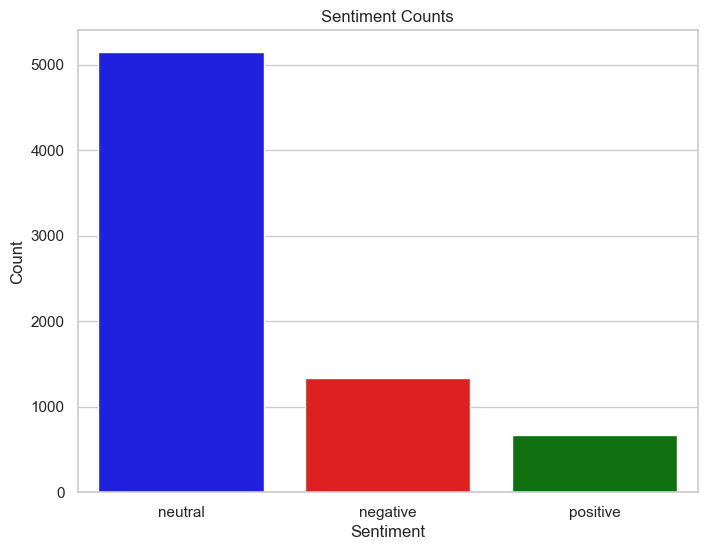

In [84]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

sns.countplot(x='sentiment', data=normalised_data, palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})

plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.show()

**Pie Chart of Sentiment Count Percentage**

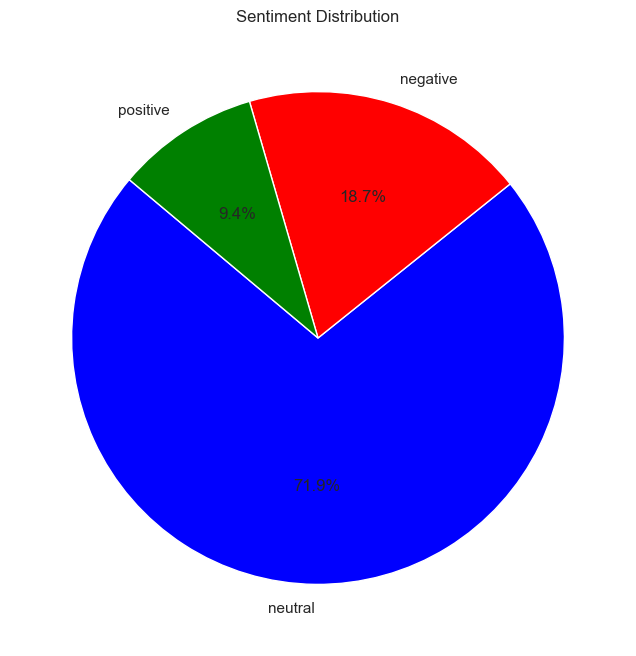

In [85]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 8))

sentiment_palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'}

sentiment_counts = normalised_data['sentiment'].value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=[sentiment_palette[s] for s in labels])
plt.title('Sentiment Distribution')

plt.show()

**Box Plot of Text Length Based on Sentiment**

C:\Users\Faris\AppData\Local\Temp\ipykernel_32588\3596644793.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='Text_Length', data=normalised_data, palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})


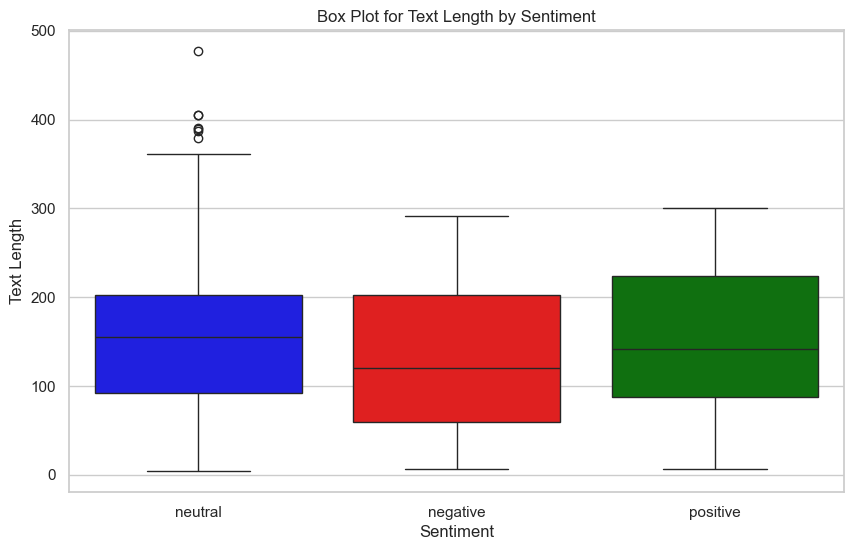

In [86]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Add a column for text length
normalised_data['Text_Length'] = normalised_data['text'].apply(len)

# Plot the box plot with sentiment_palette
sns.boxplot(x='sentiment', y='Text_Length', data=normalised_data, palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.title('Box Plot for Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')

plt.show()

C:\Users\Faris\AppData\Local\Temp\ipykernel_32588\1590972106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='Text_Length', data=filtered_data_text_length, palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})


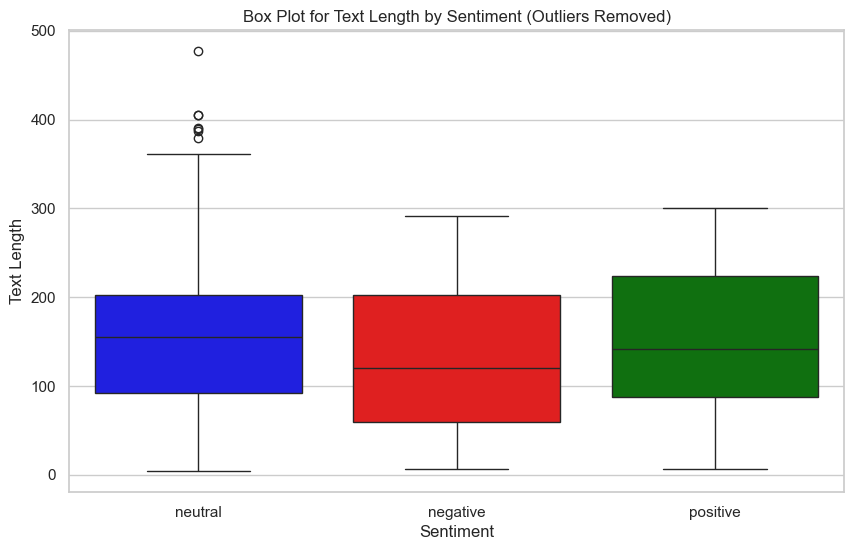

In [87]:
# Set the style for Seaborn
sns.set(style="whitegrid")

# Add a column for text length
normalised_data['Text_Length'] = normalised_data['text'].apply(len)

# Remove outliers from the 'Text_Length' variable
filtered_data_text_length = remove_outliers(normalised_data, 'Text_Length')

# Plot the box plot with sentiment_palette without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='Text_Length', data=filtered_data_text_length, palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.title('Box Plot for Text Length by Sentiment (Outliers Removed)')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')

plt.show()

**Linegraph of Sentiment Over Months**

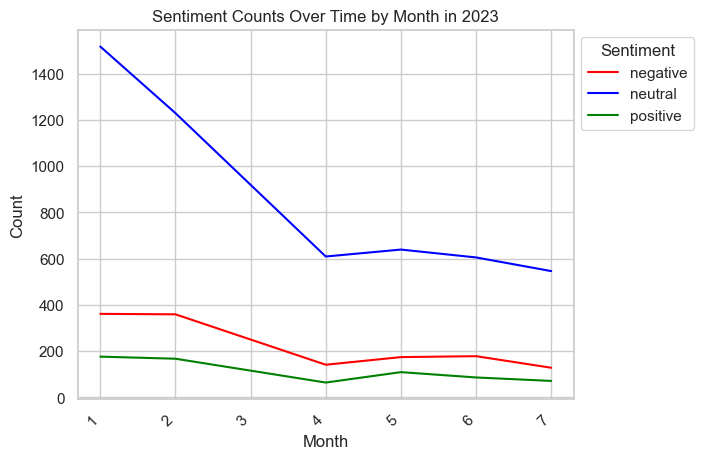

In [88]:
sns.set(style="whitegrid")

sentiment_counts_over_months = normalised_data.groupby(['month', 'sentiment']).size().reset_index(name='Count')

sns.lineplot(x='month', y='Count', hue='sentiment', data=sentiment_counts_over_months, palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.title('Sentiment Counts Over Time by Month in 2023')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Sentiment', bbox_to_anchor=(1, 1), loc='upper left')

# Optionally rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

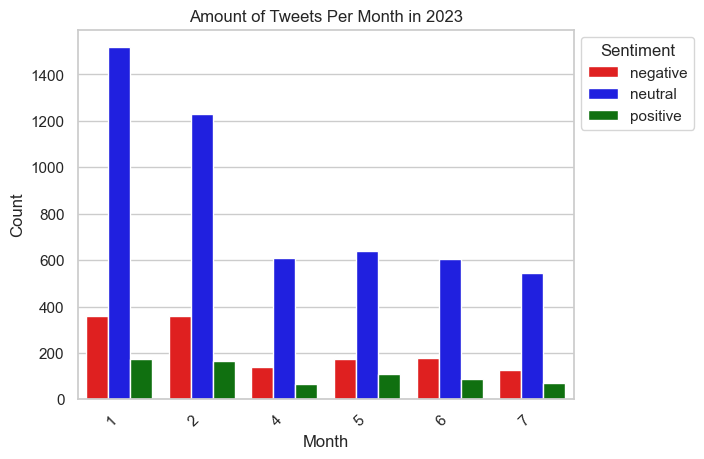

In [89]:
sns.set(style="whitegrid")

sentiment_counts_over_months = normalised_data.groupby(['month', 'sentiment']).size().reset_index(name='Count')

sns.barplot(x='month', y='Count', hue='sentiment', data=sentiment_counts_over_months, palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.title('Amount of Tweets Per Month in 2023')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Sentiment', bbox_to_anchor=(1, 1), loc='upper left')

plt.xticks(rotation=45, ha='right')

plt.show()

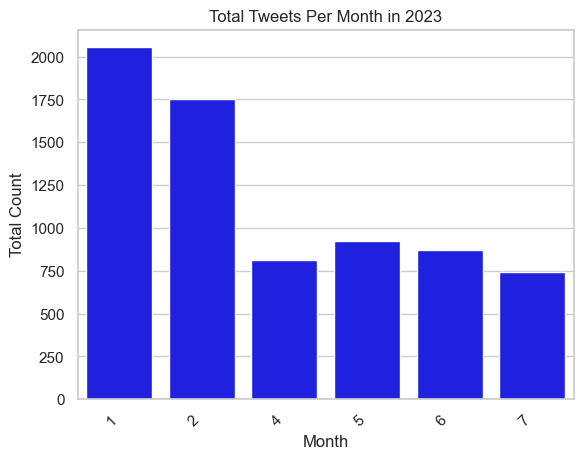

In [90]:
sentiment_counts_over_months = normalised_data.groupby(['month', 'sentiment']).size().reset_index(name='Count')

total_counts_over_months = sentiment_counts_over_months.groupby('month')['Count'].sum().reset_index(name='Total_Count')

sns.barplot(x='month', y='Total_Count', data=total_counts_over_months, color='blue')
plt.title('Total Tweets Per Month in 2023')
plt.xlabel('Month')
plt.ylabel('Total Count')

plt.xticks(rotation=45, ha='right')

plt.show()

**Bar Chart of Tweets by Day of Month**

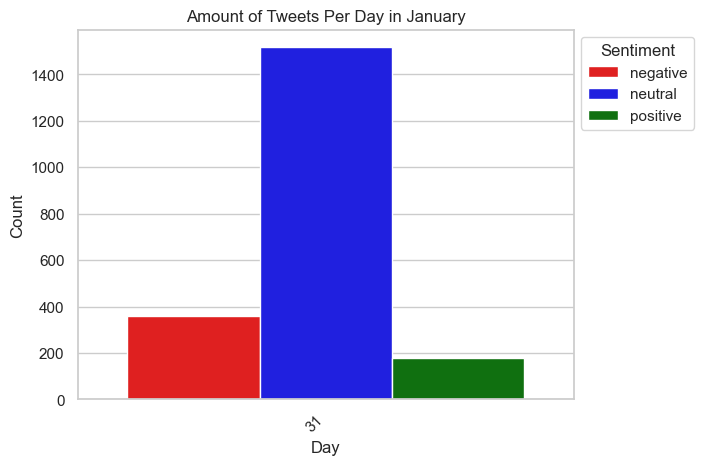

In [91]:
january_data = normalised_data[normalised_data['month'] == 1]

sentiment_counts_over_days = january_data.groupby(['day', 'sentiment']).size().reset_index(name='Count')

sns.barplot(x='day', y='Count', hue='sentiment', data=sentiment_counts_over_days, palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.title('Amount of Tweets Per Day in January')
plt.xlabel('Day')
plt.ylabel('Count')
plt.legend(title='Sentiment', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.show()

**Linegraph of Sentiment Over Time of Day**

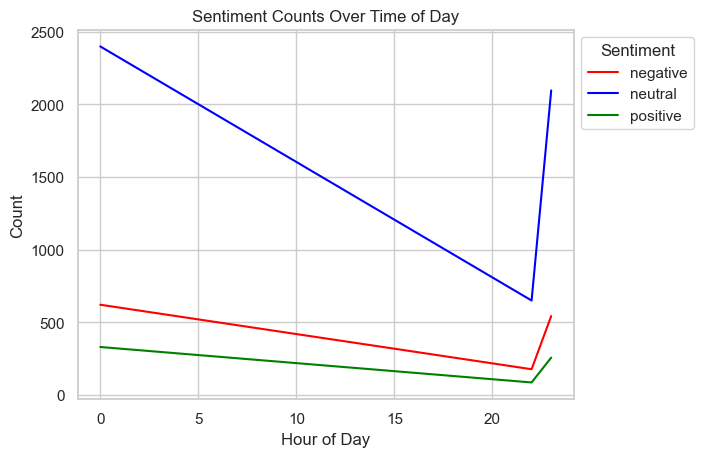

In [92]:
sns.set(style="whitegrid")

sentiment_counts_over_time = normalised_data.groupby(['hours', 'sentiment']).size().reset_index(name='Count')

sns.lineplot(x='hours', y='Count', hue='sentiment', data=sentiment_counts_over_time, palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.title('Sentiment Counts Over Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.legend(title='Sentiment', bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

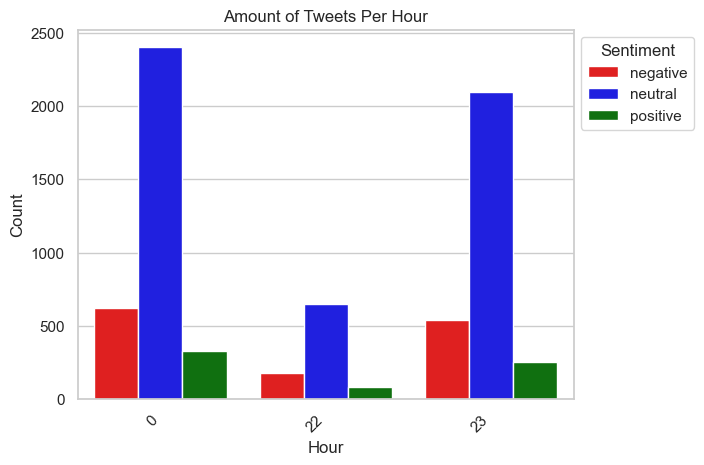

In [93]:
sns.set(style="whitegrid")

sentiment_counts_over_time = normalised_data.groupby(['hours', 'sentiment']).size().reset_index(name='Count')

sns.barplot(x='hours', y='Count', hue='sentiment', data=sentiment_counts_over_time, palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.title('Amount of Tweets Per Hour')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.legend(title='Sentiment', bbox_to_anchor=(1, 1), loc='upper left')

plt.xticks(rotation=45, ha='right')

plt.show()

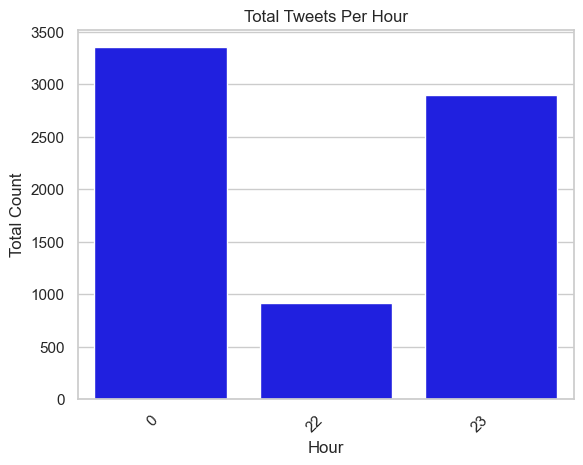

In [94]:
total_counts_over_time = normalised_data.groupby('hours').size().reset_index(name='Total Count')

sns.barplot(x='hours', y='Total Count', data=total_counts_over_time, color='blue')
plt.title('Total Tweets Per Hour')
plt.xlabel('Hour')
plt.ylabel('Total Count')

plt.xticks(rotation=45, ha='right')

plt.show()

**Word Cloud of Tweets Based on Sentiment**

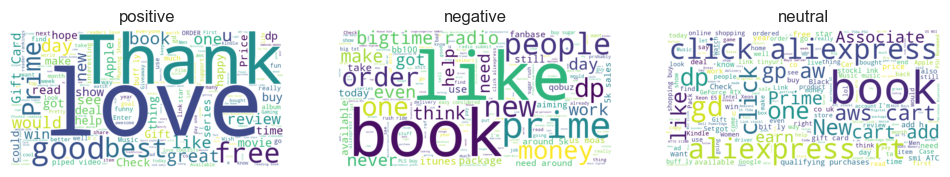

In [95]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

def generate_wordcloud(sentiment):
    subset = normalised_data[normalised_data['sentiment'] == sentiment]
    text = ' '.join(subset['text'])

    stop_words = set(stopwords.words('english'))
    stop_words.update(['amazon', '&', 'amazon.', '.', '-', '@amazon', '3', 'via', ':', '#amazon', 'com', 'amzn', 'get', "it's"])

    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(text)

    plt.subplot(1, 3, sentiment_order[sentiment])  # Assuming you have three sentiments (adjust as needed)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(sentiment)
    plt.axis('off')

sentiment_order = {'positive': 1, 'negative': 2, 'neutral': 3}

for sentiment in sentiment_order:
    generate_wordcloud(sentiment)
plt.show()


**Horizontal Bar Chart of Most Used Positive Sentiment Keywords**

C:\Users\Faris\AppData\Local\Temp\ipykernel_32588\3038373359.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_positive_word_counts.head(10), palette=sns.color_palette("Greens_r", n_colors=10))


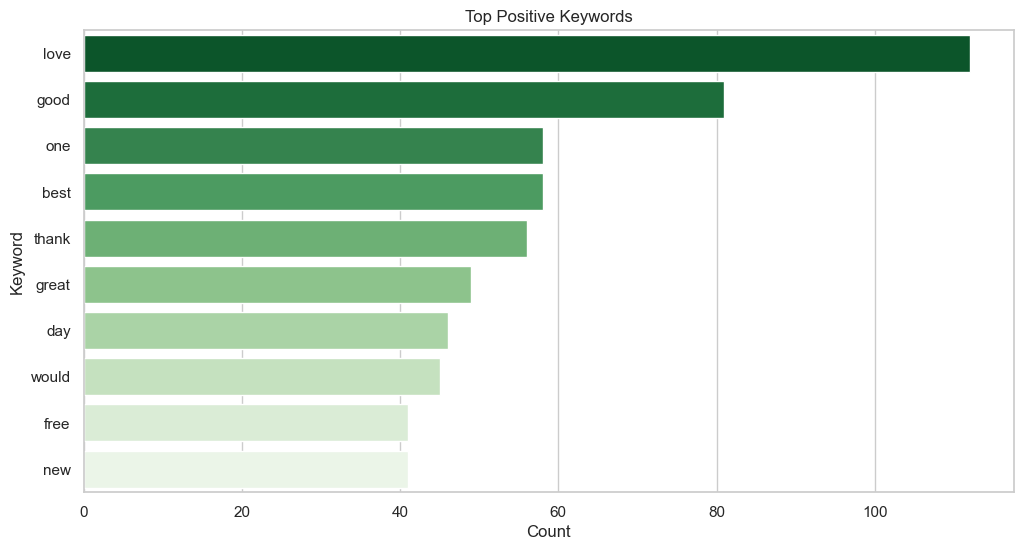

In [96]:
# Extract positive keywords and their counts, excluding 'amazon' and '&'
positive_df = normalised_data[normalised_data['sentiment'] == 'positive']
positive_text = ' '.join(positive_df['text'])

# Tokenize and preprocess the text, removing stopwords and specific keywords
stop_words = set(stopwords.words('english'))
stop_words.update(['amazon', '&', 'amazon.', '.', '-', '@amazon', '3', 'via', ':', '#amazon', 'com', 'amzn', 'get', "it's", 'like'])  # Add additional keywords to exclude
positive_words_list = [word.lower() for word in positive_text.split() if word.lower() not in stop_words]
positive_word_counts = Counter(positive_words_list)

# Convert the Counter to a DataFrame for easier plotting
df_positive_word_counts = pd.DataFrame(list(positive_word_counts.items()), columns=['Word', 'Count'])

# Sort the DataFrame by Count in descending order
df_positive_word_counts = df_positive_word_counts.sort_values(by='Count', ascending=False)

# Plot the horizontal bar chart with different shades of green (reversed order)
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=df_positive_word_counts.head(10), palette=sns.color_palette("Greens_r", n_colors=10))
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.title('Top Positive Keywords')
plt.show()

**Horizontal Bar Chart of Most Used Negative Sentiment Keywords**

C:\Users\Faris\AppData\Local\Temp\ipykernel_32588\2550440795.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_negative_word_counts.head(10), palette=sns.color_palette("Reds_r", n_colors=10))


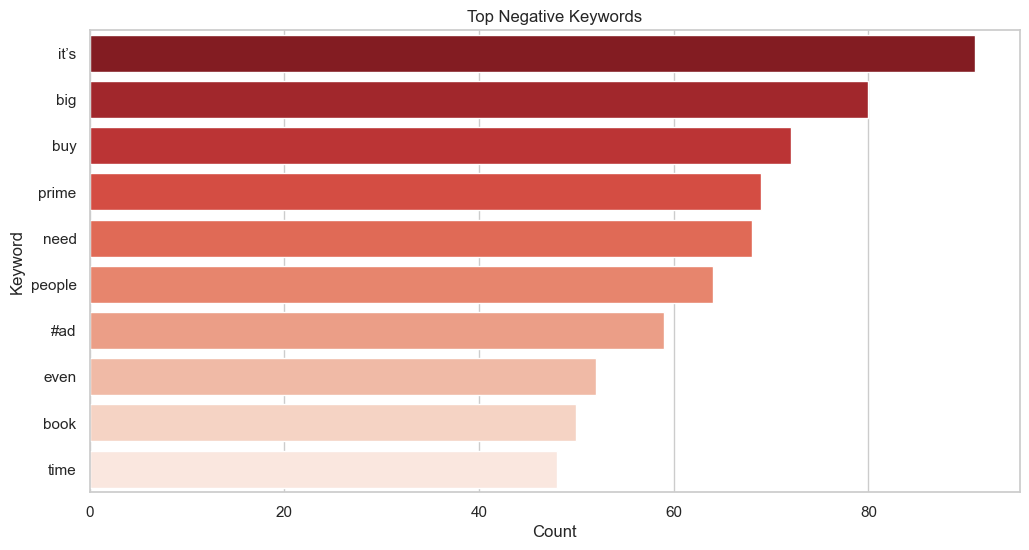

In [97]:
# Extract positive keywords and their counts, excluding 'amazon' and '&'
negative_df = normalised_data[normalised_data['sentiment'] == 'negative']
negative_text = ' '.join(negative_df['text'])

# Tokenize and preprocess the text, removing stopwords and specific keywords
stop_words = set(stopwords.words('english'))
stop_words.update(['amazon', '&', 'amazon.', '.', '-', '@amazon', '3', 'via', ':', '#amazon', 'com', 'amzn', 'get', "it's", "like"])  # Add additional keywords to exclude
negative_words_list = [word.lower() for word in negative_text.split() if word.lower() not in stop_words]
negative_word_counts = Counter(negative_words_list)

# Convert the Counter to a DataFrame for easier plotting
df_negative_word_counts = pd.DataFrame(list(negative_word_counts.items()), columns=['Word', 'Count'])

# Sort the DataFrame by Count in descending order
df_negative_word_counts = df_negative_word_counts.sort_values(by='Count', ascending=False)

# Plot the horizontal bar chart with different shades of red
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=df_negative_word_counts.head(10), palette=sns.color_palette("Reds_r", n_colors=10))
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.title('Top Negative Keywords')
plt.show()

**Stacked Bar Chart of Sentiment Based on Verified Status**

<Figure size 2500x1500 with 0 Axes>

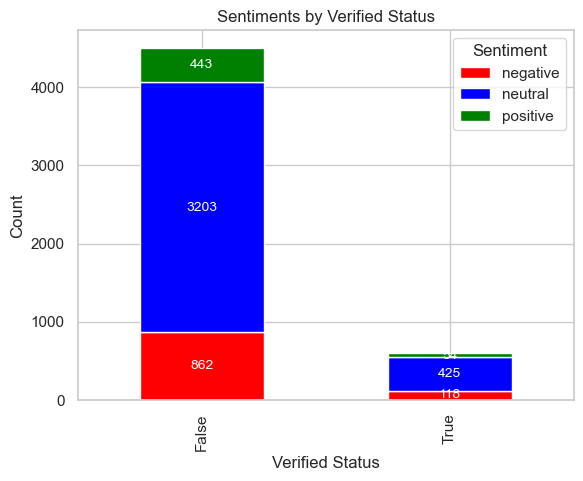

In [98]:
sentiment_counts = normalised_data.groupby(['verified', 'sentiment']).size().reset_index(name='count')

pivot_df = sentiment_counts.pivot(index='verified', columns='sentiment', values='count').fillna(0)

colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}

plt.figure(figsize=(25, 15))

ax = pivot_df.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_df.columns])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{int(height)}', (x + width / 2, y + height / 2), ha='center', va='center', color='white', fontsize=10)

plt.title('Sentiments by Verified Status')
plt.xlabel('Verified Status')
plt.ylabel('Count')
plt.legend(title='Sentiment', bbox_to_anchor=(1, 1))

plt.show()

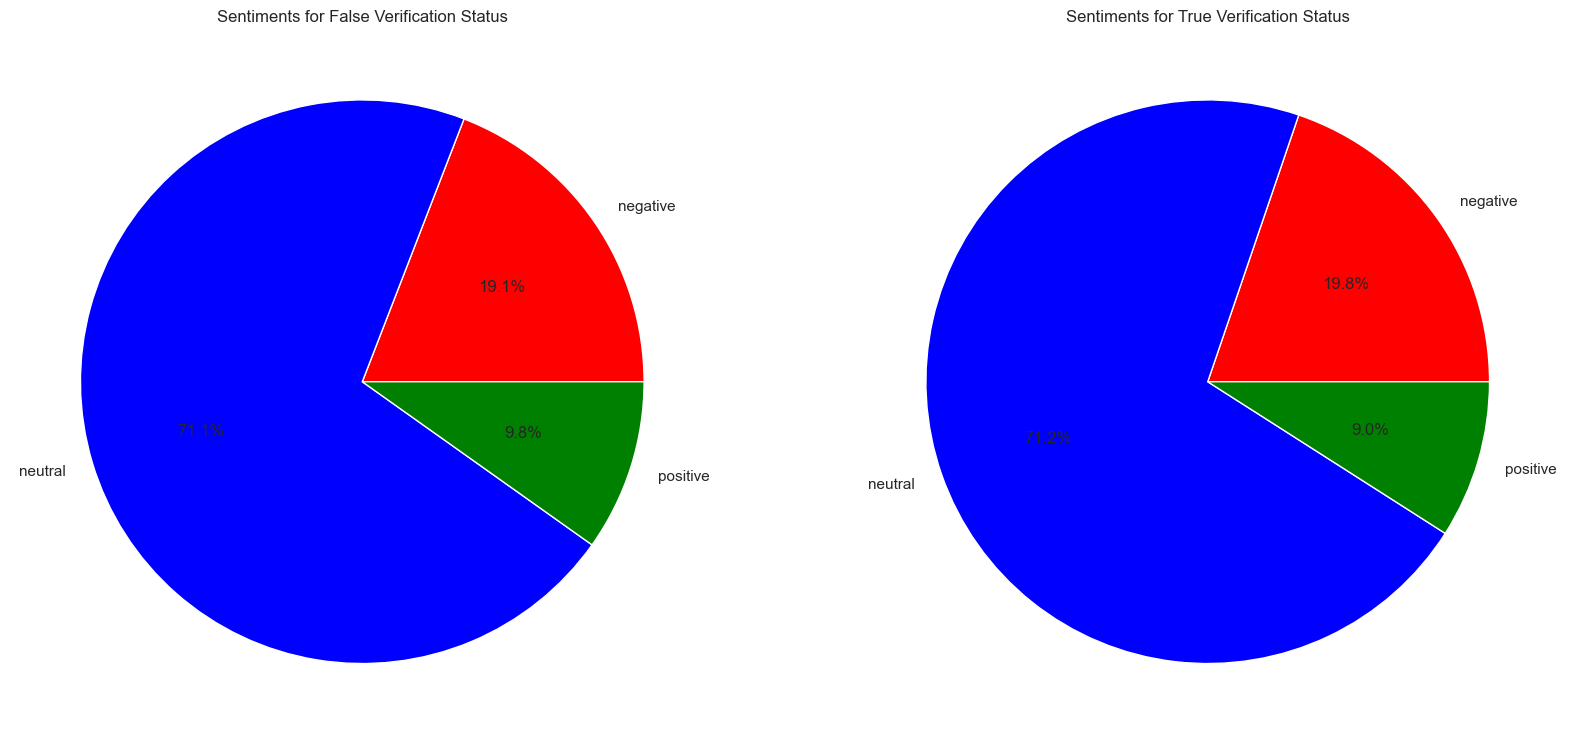

In [99]:
sentiment_counts = normalised_data.groupby(['verified', 'sentiment']).size().reset_index(name='count')

pivot_df = sentiment_counts.pivot(index='verified', columns='sentiment', values='count').fillna(0)

totals = pivot_df.sum(axis=1)

percentage_df = pivot_df.divide(totals, axis=0) * 100

colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

for idx, verified_status in enumerate(percentage_df.index):
    ax = axs[idx]
    percentages = percentage_df.loc[verified_status]
    ax.pie(percentages, labels=percentages.index, autopct='%1.1f%%', colors=[colors[col] for col in percentages.index])
    verified_status_str = str(verified_status).capitalize()
    ax.set_title(f'Sentiments for {verified_status_str} Verification Status')

plt.show()

**Violin Plot for Sentiment Based on Likes**

C:\Users\Faris\AppData\Local\Temp\ipykernel_32588\1501330721.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='sentiment', y='likes', data=normalised_data, palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})


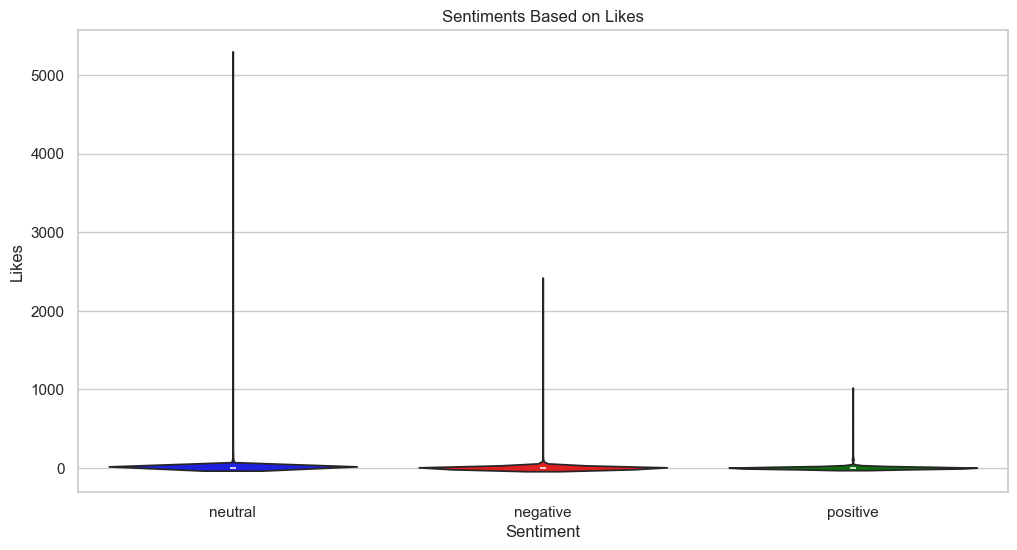

In [100]:
# Violin plot for sentiments based on the number of likes
plt.figure(figsize=(12, 6))
sns.violinplot(x='sentiment', y='likes', data=normalised_data, palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.title('Sentiments Based on Likes')
plt.xlabel('Sentiment')
plt.ylabel('Likes')
plt.show()

C:\Users\Faris\AppData\Local\Temp\ipykernel_32588\3421411751.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='sentiment', y='likes', data=filtered_data_likes, palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})


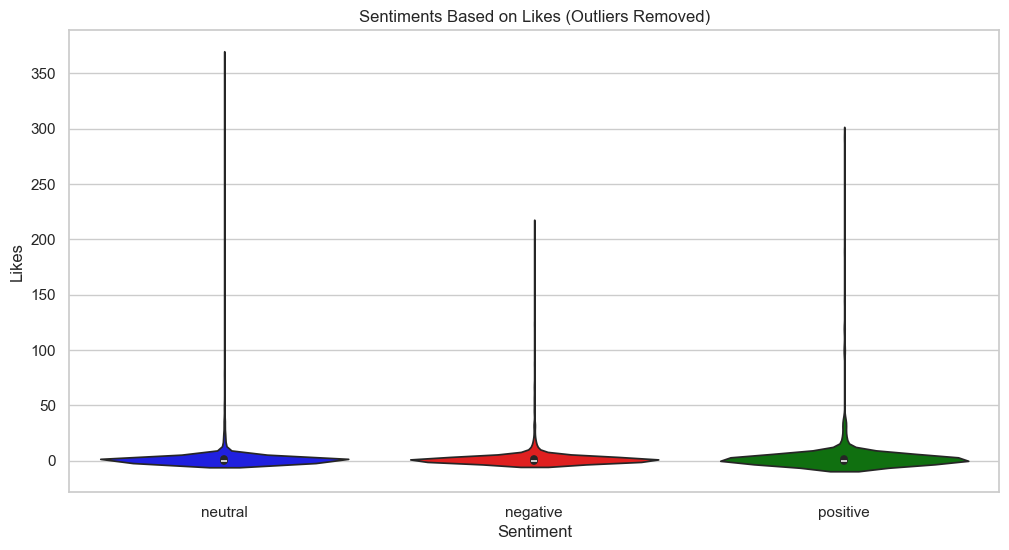

In [101]:
# Set the style for Seaborn
sns.set(style="whitegrid")

# Remove outliers from the 'likes' variable
filtered_data_likes = remove_outliers(normalised_data, 'likes')

# Violin plot for sentiments based on the number of likes without outliers
plt.figure(figsize=(12, 6))
sns.violinplot(x='sentiment', y='likes', data=filtered_data_likes, palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.title('Sentiments Based on Likes (Outliers Removed)')
plt.xlabel('Sentiment')
plt.ylabel('Likes')
plt.show()

**Pie Chart of Sentiment of Top Locations**

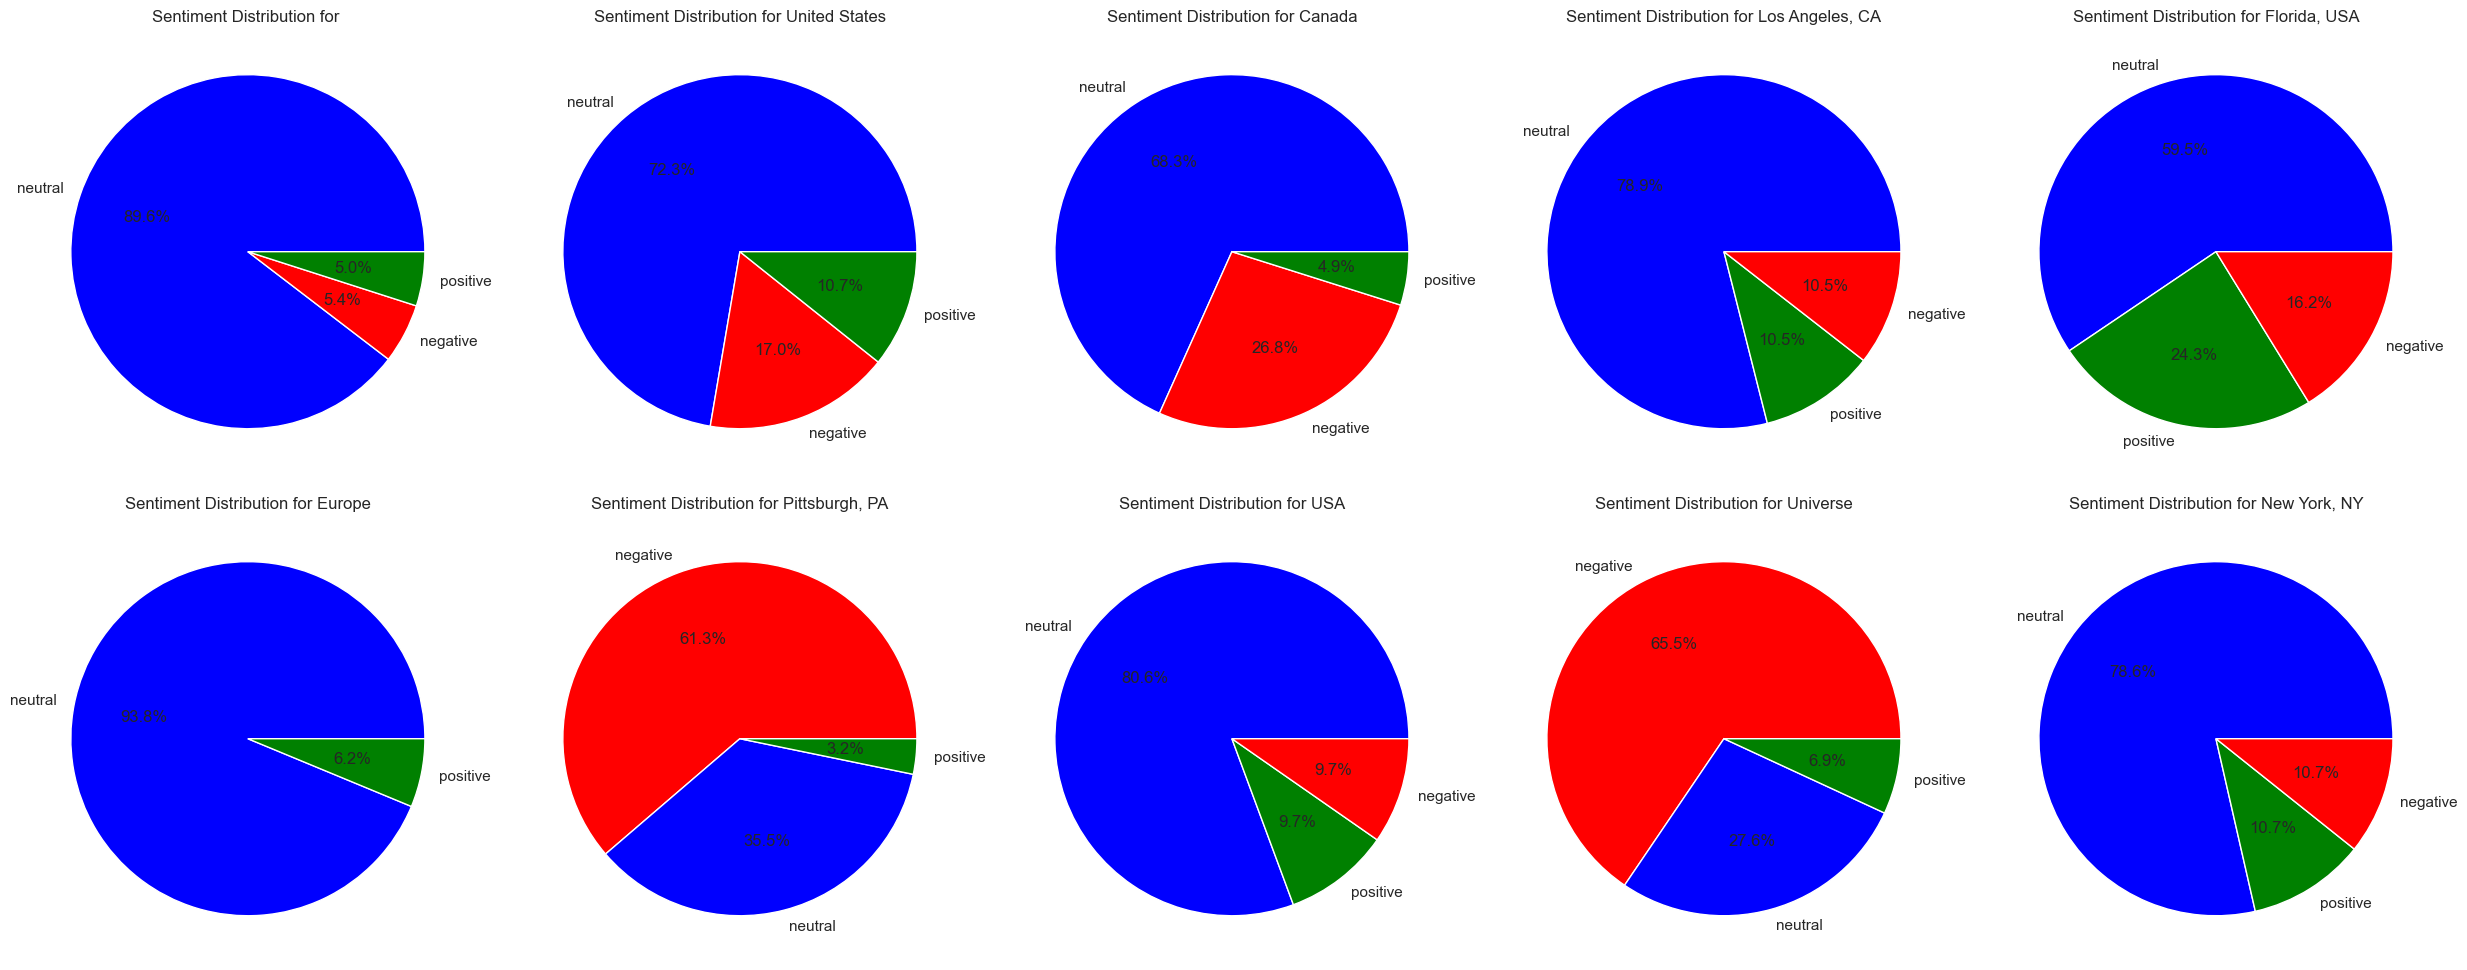

In [102]:
sns.set(style="whitegrid")

normalised_data['user/location'] = normalised_data['user/location'].str.encode('ascii', 'ignore').str.decode('utf-8')

top_locations = normalised_data['user/location'].value_counts().nlargest(10).index

num_locations = len(top_locations)
num_cols = 5
num_rows = int(np.ceil(num_locations / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 5 * num_rows))

axes = axes.flatten()

colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}

for i, location in enumerate(top_locations):
    location_data = normalised_data[normalised_data['user/location'] == location]

    ax = axes[i]

    sentiment_counts = location_data['sentiment'].value_counts()
    ax.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=[colors.get(sentiment, 'gray') for sentiment in sentiment_counts.index])
    ax.set_title(f'Sentiment Distribution for {location}')

for i in range(num_locations, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


**Bar Chart of Top Locations With Positive Sentiment**

C:\Users\Faris\AppData\Local\Temp\ipykernel_32588\2595185380.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['user/location'] = filtered_data['user/location'].str.encode('ascii', 'ignore').str.decode('utf-8')


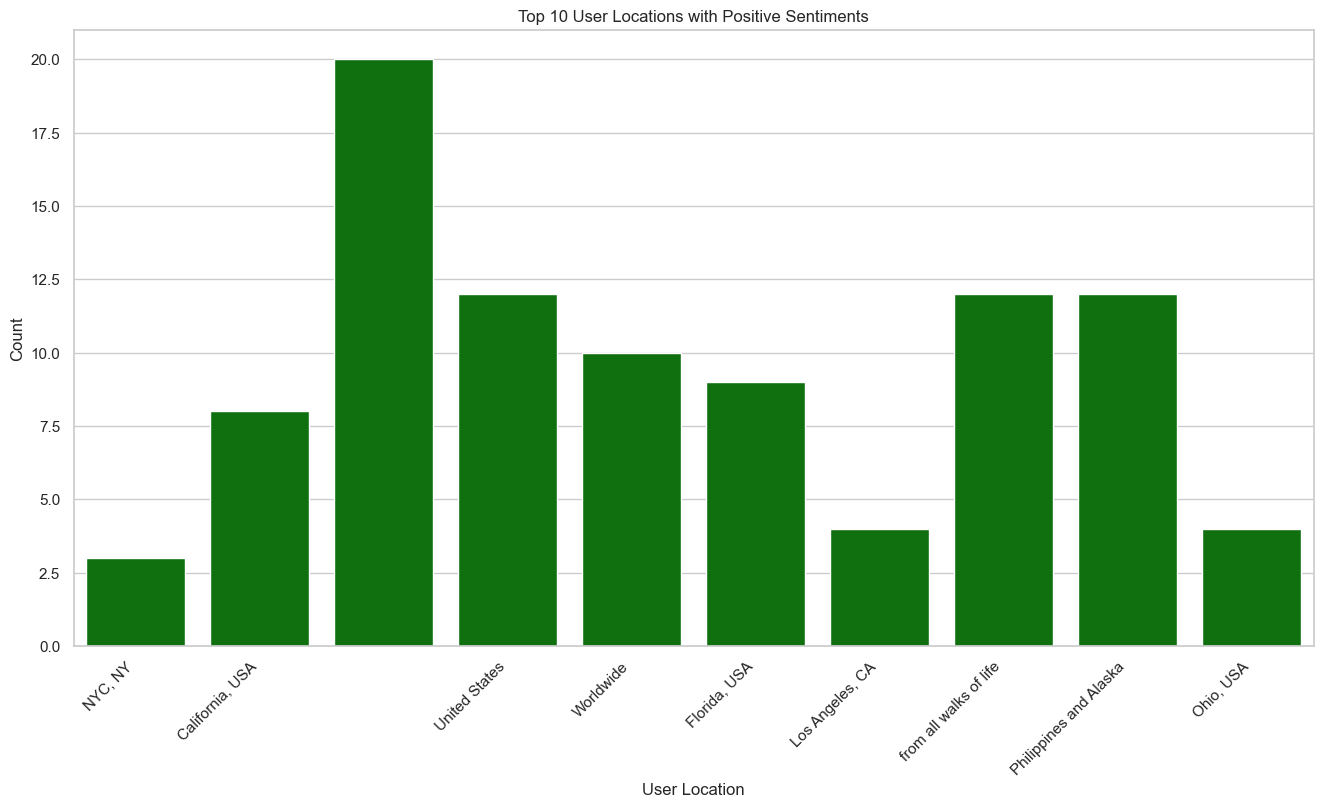

In [104]:
positive_data = normalised_data[normalised_data['sentiment'] == 'positive']

top_locations = normalised_data['user/location'].value_counts().nlargest(10).index

filtered_data = normalised_data[(normalised_data['user/location'].isin(top_locations))]

filtered_data['user/location'] = filtered_data['user/location'].str.encode('ascii', 'ignore').str.decode('utf-8')

top_positive_locations = positive_data['user/location'].value_counts().nlargest(10).index

filtered_positive_data = positive_data[positive_data['user/location'].isin(top_positive_locations)]

sns.set(style="whitegrid")

plt.figure(figsize=(16, 8))
sns.countplot(x='user/location', data=filtered_positive_data, color='green')
plt.title('Top 10 User Locations with Positive Sentiments')
plt.xlabel('User Location')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

C:\Users\Faris\AppData\Local\Temp\ipykernel_32588\47374215.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['user/location'] = filtered_data['user/location'].str.encode('ascii', 'ignore').str.decode('utf-8')


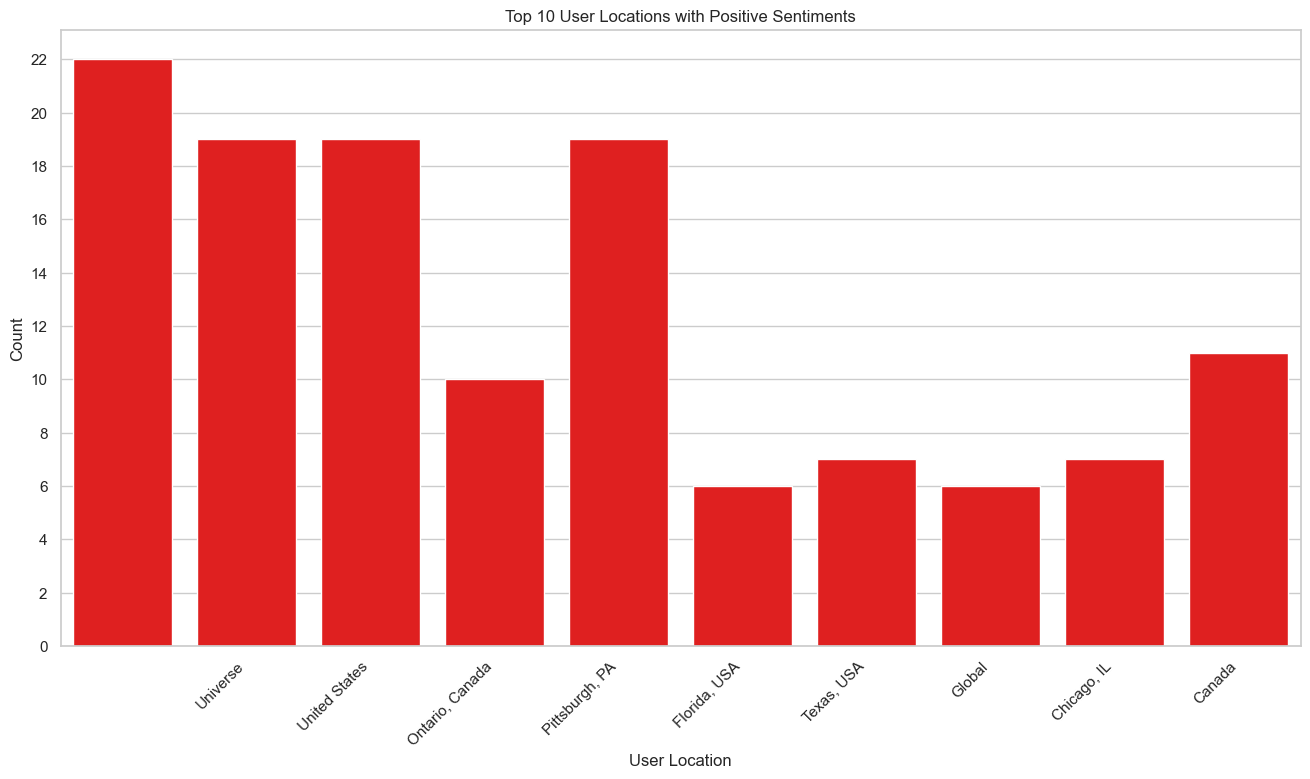

In [105]:
negative_data = normalised_data[normalised_data['sentiment'] == 'negative']

top_locations = normalised_data['user/location'].value_counts().nlargest(10).index

filtered_data = normalised_data[(normalised_data['user/location'].isin(top_locations))]

filtered_data['user/location'] = filtered_data['user/location'].str.encode('ascii', 'ignore').str.decode('utf-8')

top_negative_locations = negative_data['user/location'].value_counts().nlargest(10).index

filtered_negative_data = negative_data[negative_data['user/location'].isin(top_negative_locations)]

sns.set(style="whitegrid")

plt.figure(figsize=(16, 8))
sns.countplot(x='user/location', data=filtered_negative_data, color='red')
plt.title('Top 10 User Locations with Positive Sentiments')
plt.xlabel('User Location')
plt.ylabel('Count')
#Fix issue with lines incrementing by 0.5
plt.yticks(range(0, max(filtered_negative_data['user/location'].value_counts()) + 2, 2))
plt.xticks(rotation=45, ha='right')
plt.show()

**Bar Chart of Top Locations With Negative Sentiment**

**Scatterplot of Sentiment Based on Tweet Statistics**

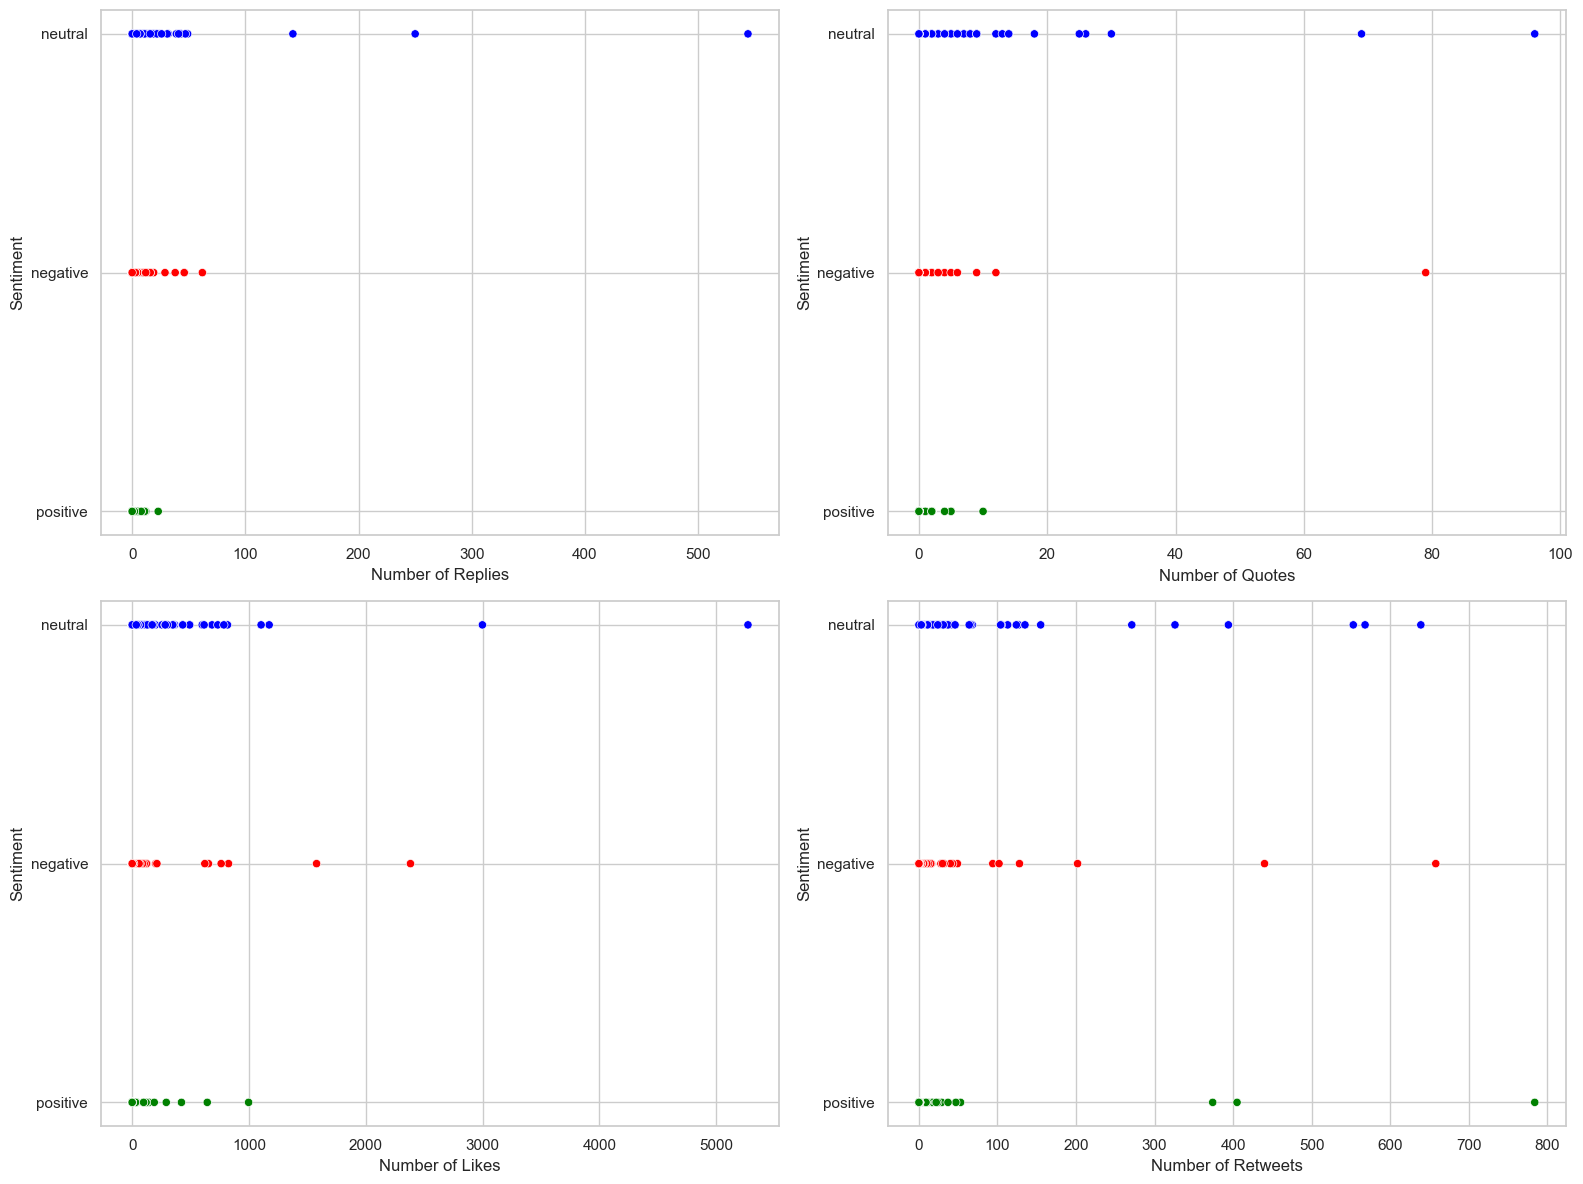

In [106]:
sns.set(style="whitegrid")

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
sns.scatterplot(x='replies', y='sentiment', data=normalised_data, hue='sentiment', palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.xlabel('Number of Replies')
plt.ylabel('Sentiment')
plt.legend().set_visible(False)

plt.subplot(2, 2, 2)
sns.scatterplot(x='quotes', y='sentiment', data=normalised_data, hue='sentiment', palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.xlabel('Number of Quotes')
plt.ylabel('Sentiment')
plt.legend().set_visible(False)

plt.subplot(2, 2, 3)
sns.scatterplot(x='likes', y='sentiment', data=normalised_data, hue='sentiment', palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.xlabel('Number of Likes')
plt.ylabel('Sentiment')
plt.legend().set_visible(False)

plt.subplot(2, 2, 4)
sns.scatterplot(x='retweets', y='sentiment', data=normalised_data, hue='sentiment', palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.xlabel('Number of Retweets')
plt.ylabel('Sentiment')
plt.legend().set_visible(False)

plt.tight_layout()

plt.show()

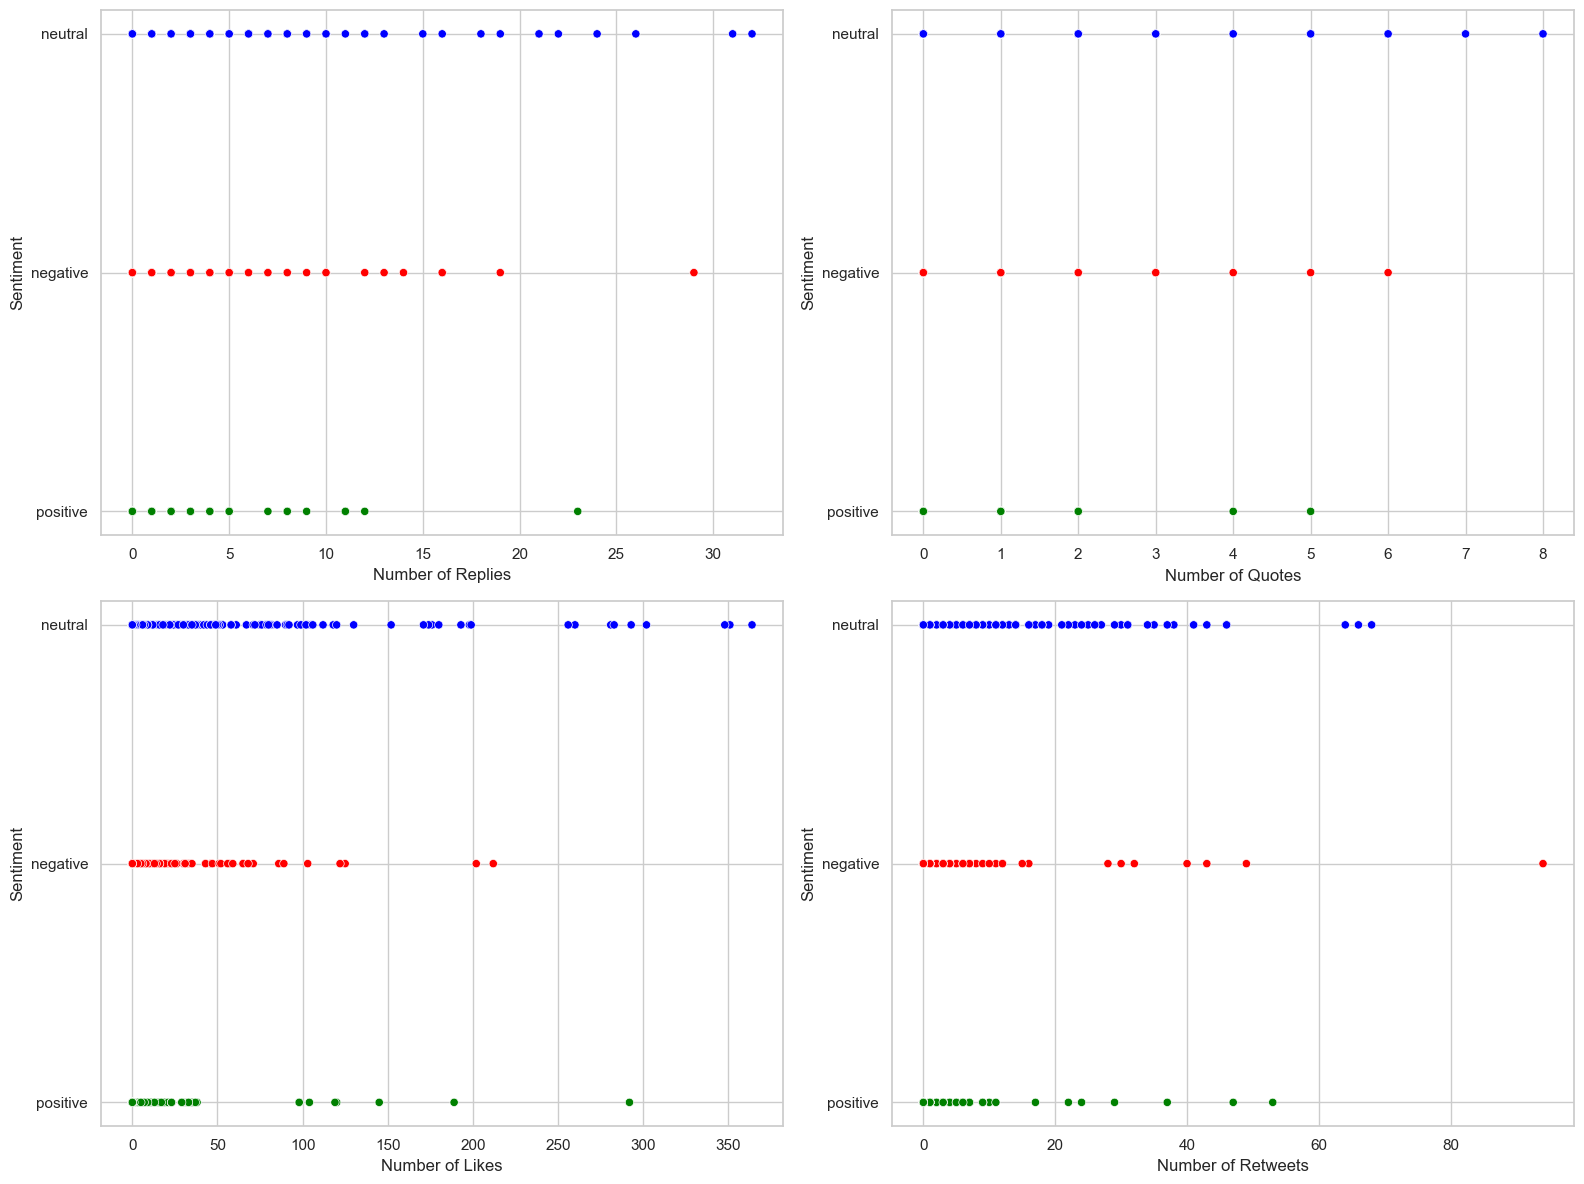

In [107]:
sns.set(style="whitegrid")

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
filtered_data_replies = remove_outliers(normalised_data, 'replies')
sns.scatterplot(x='replies', y='sentiment', data=filtered_data_replies, hue='sentiment', palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.xlabel('Number of Replies')
plt.ylabel('Sentiment')
plt.legend().set_visible(False)

plt.subplot(2, 2, 2)
filtered_data_quotes = remove_outliers(normalised_data, 'quotes')
sns.scatterplot(x='quotes', y='sentiment', data=filtered_data_quotes, hue='sentiment', palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.xlabel('Number of Quotes')
plt.ylabel('Sentiment')
plt.legend().set_visible(False)

plt.subplot(2, 2, 3)
filtered_data_likes = remove_outliers(normalised_data, 'likes')
sns.scatterplot(x='likes', y='sentiment', data=filtered_data_likes, hue='sentiment', palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.xlabel('Number of Likes')
plt.ylabel('Sentiment')
plt.legend().set_visible(False)

plt.subplot(2, 2, 4)
filtered_data_retweets = remove_outliers(normalised_data, 'retweets')
sns.scatterplot(x='retweets', y='sentiment', data=filtered_data_retweets, hue='sentiment', palette={'neutral': 'blue', 'positive': 'green', 'negative': 'red'})
plt.xlabel('Number of Retweets')
plt.ylabel('Sentiment')
plt.legend().set_visible(False)

plt.tight_layout()

plt.show()


# GUI


In [8]:
%%writefile Sentiment_Analysis_GUI.py
import streamlit as st
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Input, Conv1D, MaxPooling1D, Flatten
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm

#Specify the file path for Test Data Set
file_path = "Training Dataset/Original (No Pre-Processing)/Kaggle Sentiment Tweets (Original).csv"
test_data = pd.read_csv(file_path)

#Testing and Training Model on Test Dataset
normalised_test_data = test_data.copy()

x = normalised_test_data['text'].values
y = normalised_test_data["sentiment"].values

#Splitting The Data Into Training & Testing Sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

#Run The Model
model = SVC(C=1, kernel='linear')
model.fit(x_train_tfidf, y_train)

#Initialize session_state if it doesn't exist
if 'data' not in st.session_state:
    st.session_state.data = None

if 'normalised_data' not in st.session_state:
    st.session_state.normalised_data = None

#Load CSV function
def load_csv(uploaded_file):
    data = pd.read_csv(uploaded_file)
    columns_to_keep = [
    'id', 'likes', 'quotes', 'replies', 'retweets', 'searchQuery', 'text', 'timestamp', 'user/location', 'verified'
    ]

    data = data[columns_to_keep]
    return data

# Timestamp Convert
def check_and_convert_timestamp():
    if st.session_state.data is not None:
        try:
            st.session_state.data['timestamp'] = pd.to_datetime(st.session_state.data['timestamp'], format='%d/%m/%Y %H:%M')
        except ValueError:
            try:
                st.session_state.data['timestamp'] = pd.to_datetime(st.session_state.data['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')
            except ValueError:
                print("Error: Unable to parse timestamp in either format")

                # Check if 'timestamp' is present in data before accessing
                if 'timestamp' in st.session_state.data.columns:
                    st.session_state.data['month'] = st.session_state.data['timestamp'].dt.month
                    st.session_state.data['hours'] = st.session_state.data['timestamp'].dt.hour
                    st.session_state.data['day'] = st.session_state.data['timestamp'].dt.day


#Remove Outliers Function
def remove_outliers(data, variable, alpha=0.05):
    test_results = sm.OLS(data[variable], sm.add_constant(np.arange(len(data)))).fit().outlier_test()
    outliers = test_results[test_results['bonf(p)'] < alpha].index
    return data[~data.index.isin(outliers)]

#GUI PAGE ELEMENTS
menu_option = st.sidebar.selectbox(
    "Select a Page", ("Run Sentiment Analysis Model", "Sentiment Distribution", "Sentiment by Location", "Sentiment by Tweet Statistic", "Key Word Analysis"))



#RUN SENTIMENT ANALYSIS MODEL PAGE
if menu_option == "Run Sentiment Analysis Model":
    st.title("Run Sentiment Analysis Model")

    uploaded_file = st.file_uploader("Please Upload Your CSV File", type=["csv"])

    #Load data only if it's not already loaded
    if uploaded_file is not None and st.session_state.data is None:
        st.session_state.data = load_csv(uploaded_file)

    #Display the contents of the CSV file
    if st.session_state.data is not None:
        st.write("Dataframe before Model Run")
        st.write(st.session_state.data)

        #Button to run sentiment analysis and print the new DataFrame
        if st.button("Run Sentiment Analysis Model on Dataframe"):
            normalised_data = st.session_state.data.copy()
            tweets = normalised_data['text']
            tweets_tfidf = tfidf_vectorizer.transform(tweets)
            sentiment_prediction = model.predict(tweets_tfidf)
            normalised_data['sentiment'] = sentiment_prediction
            st.session_state.normalised_data = normalised_data
            st.write("DataFrame with Sentiment Analysis:")
            st.write(normalised_data[['id', 'text', 'sentiment']])



#SENTIMENT DISTRIBUTION PAGE
elif menu_option == "Sentiment Distribution":
    st.title("Sentiment Distributions")

    # Check if sentiment analysis has been performed
    if st.session_state.normalised_data is not None and 'sentiment' in st.session_state.normalised_data.columns:
        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.countplot(x='sentiment', data=st.session_state.normalised_data, palette={'positive': 'green', 'negative': 'red', 'neutral': 'blue'}, ax=ax)
        ax.set_title('Sentiment Distribution Bar Chart')
        ax.set_xlabel('Sentiment')
        ax.set_ylabel('Count')
        st.pyplot(fig)

        sentiment_counts = st.session_state.normalised_data['sentiment'].value_counts()
        labels = sentiment_counts.index
        sizes = sentiment_counts.values

        # Define sentiment_palette
        sentiment_palette = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}

        # Plot the pie chart with custom colors
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=[sentiment_palette[label.lower()] for label in labels])
        ax.set_title('Sentiment Distribution Pie Chart')
        st.pyplot(fig)



#KEY WORD ANALYSIS PAGE
elif menu_option == "Key Word Analysis":
    if st.session_state.normalised_data is not None and 'sentiment' in st.session_state.normalised_data.columns:
      st.title("Most Used Keywords")



#WORDCLOUDS OF SENTIMENTS
      def generate_wordcloud(ax, sentiment):
          subset = st.session_state.normalised_data[st.session_state.normalised_data['sentiment'] == sentiment]
          text = ' '.join(subset['text'])

          stop_words = set(stopwords.words('english'))
          stop_words.update(['amazon', '&', 'amazon.', '.', '-', '@amazon', '3', 'via', ':', '#amazon', 'com', 'amzn', 'get', "it's"])

          wordcloud = WordCloud(width=400, height=200, background_color='white', stopwords=stop_words).generate(text)

          ax.imshow(wordcloud, interpolation='bilinear')
          ax.set_title(sentiment)
          ax.axis('off')

      sentiment_order = ['positive', 'negative', 'neutral']

      fig, axs = plt.subplots(1, len(sentiment_order), figsize=(12, 6))

      for i, sentiment in enumerate(sentiment_order):
          generate_wordcloud(axs[i], sentiment)

      st.pyplot(fig)



#POSITIVE KEYWORDS BAR CHART
      st.title("Top Positive Keywords")

      positive_df = st.session_state.normalised_data[st.session_state.normalised_data['sentiment'] == 'positive']
      positive_text = ' '.join(positive_df['text'])

      stop_words = set(stopwords.words('english'))
      stop_words.update(['amazon', '&', 'amazon.', '.', '-', '@amazon', '3', 'via', ':', '#amazon', 'com', 'amzn', 'get', "it's"])
      positive_words_list = [word.lower() for word in positive_text.split() if word.lower() not in stop_words]
      positive_word_counts = Counter(positive_words_list)

      df_positive_word_counts = pd.DataFrame(list(positive_word_counts.items()), columns=['Word', 'Count'])

      df_positive_word_counts = df_positive_word_counts.sort_values(by='Count', ascending=False)

      fig, ax = plt.subplots(figsize=(12, 6))
      sns.barplot(x='Count', y='Word', data=df_positive_word_counts.head(10), palette='Greens_r')
      ax.set(xlabel='Count', ylabel='Keyword', title='Top Positive Keywords')

      st.pyplot(fig)



#NEGATIVE KEYWORDS BAR CHART
      st.title("Top Negative Keywords")

      negative_df = st.session_state.normalised_data[st.session_state.normalised_data['sentiment'] == 'negative']
      negative_text = ' '.join(negative_df['text'])

      stop_words = set(stopwords.words('english'))
      stop_words.update(['amazon', '&', 'amazon.', '.', '-', '@amazon', '3', 'via', ':', '#amazon', 'com', 'amzn', 'get', "it's"])
      negative_words_list = [word.lower() for word in negative_text.split() if word.lower() not in stop_words]
      negative_word_counts = Counter(negative_words_list)

      df_negative_word_counts = pd.DataFrame(list(negative_word_counts.items()), columns=['Word', 'Count'])

      df_negative_word_counts = df_negative_word_counts.sort_values(by='Count', ascending=False)

      fig, ax = plt.subplots(figsize=(12, 6))
      sns.barplot(x='Count', y='Word', data=df_negative_word_counts.head(10), palette='Reds_r')
      ax.set(xlabel='Count', ylabel='Keyword', title='Top Negative Keywords')

      st.pyplot(fig)



    else:
      st.warning("Perform sentiment analysis first.")



#LOCATION BASED SENTIMENT
elif menu_option == "Sentiment by Location":
    if st.session_state.normalised_data is not None and 'sentiment' in st.session_state.normalised_data.columns:

#TOP 10 POSITIVE LOCATION SENTIMENT BAR CHART
      st.title("Top 10 User Locations with Positive Sentiments")

      filtered_positive_data = st.session_state.normalised_data[st.session_state.normalised_data['sentiment'] == 'positive'].dropna(subset=['sentiment', 'user/location'])

      top_positive_locations = filtered_positive_data['user/location'].value_counts().nlargest(10).index

      filtered_positive_data = filtered_positive_data[filtered_positive_data['user/location'].isin(top_positive_locations)]

      sns.set(style="whitegrid")

      fig, ax = plt.subplots(figsize=(16, 8))

      sns.countplot(x='user/location', data=filtered_positive_data, palette='Greens_r', ax=ax)
      plt.title('Top 10 User Locations with Positive Sentiments')
      plt.xlabel('User Location')
      plt.ylabel('Count')
      plt.xticks(rotation=45, ha='right')

      st.pyplot(fig)


#TOP 10 NEGATIVE LOCATION SENTIMENT BAR CHART
      st.title("Top 10 User Locations with Negative Sentiments")

      filtered_negative_data = st.session_state.normalised_data[st.session_state.normalised_data['sentiment'] == 'negative'].dropna(subset=['sentiment', 'user/location'])

      top_negative_locations = filtered_negative_data['user/location'].value_counts().nlargest(10).index

      filtered_negative_data = filtered_negative_data[filtered_negative_data['user/location'].isin(top_negative_locations)]

      sns.set(style="whitegrid")

      fig, ax = plt.subplots(figsize=(16, 8))

      sns.countplot(x='user/location', data=filtered_negative_data, palette='Reds_r', ax=ax)
      plt.title('Top 10 User Locations with Negative Sentiments')
      plt.xlabel('User Location')
      plt.ylabel('Count')
      plt.xticks(rotation=45, ha='right')

      st.pyplot(fig)


    else:
      st.warning("Perform sentiment analysis first.")


#TWEET STATISTIC PAGE
elif menu_option == "Sentiment by Tweet Statistic":
    if st.session_state.normalised_data is not None and 'sentiment' in st.session_state.normalised_data.columns:

      st.title('Sentiment by Tweet Length')

      st.session_state.normalised_data['Text_Length'] = st.session_state.normalised_data['text'].apply(len)

      sns.set(style="whitegrid")

      filtered_data_text_length = remove_outliers(st.session_state.normalised_data, 'Text_Length')

      fig, ax = plt.subplots(figsize=(10, 6))

      sns.boxplot(x='sentiment', y='Text_Length', data=filtered_data_text_length, palette={'positive': 'green', 'negative': 'red', 'neutral': 'blue'}, ax=ax)
      plt.title('Box Plot for Text Length by Sentiment')
      plt.xlabel('Sentiment')
      plt.ylabel('Text Length')

      st.pyplot(fig)



      #SENTMENTS BY VERFIED STATUS
      st.title('Sentiments by Verified Status')

      sentiment_counts = st.session_state.normalised_data.groupby(['verified', 'sentiment']).size().reset_index(name='count')

      pivot_df = sentiment_counts.pivot(index='verified', columns='sentiment', values='count').fillna(0)

      colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}

      fig, ax = plt.subplots()

      pivot_df.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_df.columns], ax=ax)

      for p in ax.patches:
          width, height = p.get_width(), p.get_height()
          x, y = p.get_xy()
          ax.annotate(f'{int(height)}', (x + width / 2, y + height / 2), ha='center', va='center', color='white', fontsize=10)

      plt.title('Sentiments by Verified Status')
      plt.xlabel('Verified Status')
      plt.ylabel('Count')
      plt.legend(title='Sentiment', bbox_to_anchor=(1, 1))

      st.pyplot(fig)



      #SENTIMENTS BASED ON LIKES VIOLIN PLOT
      st.title('Sentiments Based on Likes')

      fig, ax = plt.subplots(figsize=(12, 6))

      filtered_data_likes = remove_outliers(st.session_state.normalised_data, 'likes')

      sns.violinplot(x='sentiment', y='likes', data=filtered_data_likes, palette=['green', 'red', 'blue'], ax=ax)

      plt.title('Sentiments Based on Likes')
      plt.xlabel('Sentiment')
      plt.ylabel('Likes')

      st.pyplot(fig)



      #SENTIMENT BASED ON TWEET STATISTICS SCATTER PLOTS
      st.title('Sentiment on Specific Tweet Statistics')

      fig, axes = plt.subplots(2, 2, figsize=(16, 12))

      filtered_data_replies = remove_outliers(st.session_state.normalised_data, 'replies')
      sns.scatterplot(x='replies', y='sentiment', data=filtered_data_replies, hue='sentiment', palette={'positive': 'green', 'negative': 'red', 'neutral': 'blue'}, ax=axes[0, 0])
      axes[0, 0].set_xlabel('Number of Replies')
      axes[0, 0].set_ylabel('Sentiment')
      axes[0, 0].legend().set_visible(False)

      filtered_data_quotes = remove_outliers(st.session_state.normalised_data, 'quotes')
      sns.scatterplot(x='quotes', y='sentiment', data=filtered_data_quotes, hue='sentiment', palette={'positive': 'green', 'negative': 'red', 'neutral': 'blue'}, ax=axes[0, 1])
      axes[0, 1].set_xlabel('Number of Quotes')
      axes[0, 1].set_ylabel('Sentiment')
      axes[0, 1].legend().set_visible(False)

      filtered_data_likes = remove_outliers(st.session_state.normalised_data, 'likes')
      sns.scatterplot(x='likes', y='sentiment', data=filtered_data_likes, hue='sentiment', palette={'positive': 'green', 'negative': 'red', 'neutral': 'blue'}, ax=axes[1, 0])
      axes[1, 0].set_xlabel('Number of Likes')
      axes[1, 0].set_ylabel('Sentiment')
      axes[1, 0].legend().set_visible(False)

      filtered_data_retweets = remove_outliers(st.session_state.normalised_data, 'retweets')
      sns.scatterplot(x='retweets', y='sentiment', data=filtered_data_retweets, hue='sentiment', palette={'positive': 'green', 'negative': 'red', 'neutral': 'blue'}, ax=axes[1, 1])
      axes[1, 1].set_xlabel('Number of Retweets')
      axes[1, 1].set_ylabel('Sentiment')
      axes[1, 1].legend().set_visible(False)

      plt.tight_layout()

      st.pyplot(fig)



    else:
      st.warning("Perform sentiment analysis first.")

Overwriting Sentiment_Analysis_GUI.py


In [7]:
#Run in terminal to launch app
#streamlit run Sentiment_Analysis_GUI.py

SyntaxError: invalid syntax (3731206228.py, line 1)